In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
mnist_train_y = hd5_open('../scratch_AKS/data/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../scratch_AKS/data/mnist_test_y.h5','main/data')
test_angles = hd5_open('../scratch_AKS/data/angles_listjl.h5','main/test_angles')
train_angles = hd5_open('../scratch_AKS/data/angles_listjl.h5','main/train_angles')

In [3]:
def prec_LDA(lda,X_test,y_test):
    y_pred = lda.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    return prec

def DHC_iso(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [4]:
mnist_DHC_train_LanRot = hd5_open('../from_cannon/2021_03_28/mnist_DHC_train_ang_LanRotResize.h5','data')
mnist_DHC_test_LanRot = hd5_open('../from_cannon/2021_03_28/mnist_DHC_test_ang_LanRotResize.h5','data')

In [5]:
mnist_DHC_outR = hd5_open('../from_cannon/2021_04_04/mnist_DHC_train_RR_wd2.h5','main/data')
mnist_DHC_outR_test = hd5_open('../from_cannon/2021_04_04/mnist_DHC_test_RR_wd2.h5','main/data')

In [8]:
angle_3_train = np.vstack([mnist_DHC_train_LanRot[1::6,:],mnist_DHC_train_LanRot[2::6,:],mnist_DHC_train_LanRot[3::6,:]])
angle_3_test = np.hstack([mnist_train_y,mnist_train_y,mnist_train_y])

In [9]:
N = 10
ldaAug = LDA(n_components=N-1)
ldaAug.fit(DHC_iso(angle_3_train,6,8), angle_3_test)

LinearDiscriminantAnalysis(n_components=9)

In [16]:
N = 10
ldaNR = LDA(n_components=N-1)
ldaNR.fit(DHC_iso(mnist_DHC_train_LanRot[0::6,:],6,8), mnist_train_y)

LinearDiscriminantAnalysis(n_components=9)

In [11]:
N = 10
ldaR = LDA(n_components=N-1)
ldaR.fit(DHC_iso(mnist_DHC_outR,6,8), mnist_train_y)

LinearDiscriminantAnalysis(n_components=9)

In [15]:
mnist_DHC_test_LanRot.shape

(1000000, 2452)

In [18]:
prec_LDA(ldaNR,DHC_iso(mnist_DHC_test_LanRot[0::100,:],6,8),mnist_test_y)

0.9347

In [19]:
prec_LDA(ldaR,DHC_iso(mnist_DHC_outR_test,6,8),mnist_test_y)

0.9228

In [20]:
prec_LDA(ldaNR,DHC_iso(mnist_DHC_outR_test,6,8),mnist_test_y)

0.8787

In [25]:
prec_LDA(ldaAug,DHC_iso(mnist_DHC_test_LanRot[0::100,:],6,8),mnist_test_y)

0.9207

In [26]:
prec_LDA(ldaAug,DHC_iso(mnist_DHC_outR_test,6,8),mnist_test_y)

0.9216

In [27]:
N = 10
ldaAugREG = LDA(n_components=N-1)
ldaAugREG.fit(angle_3_train, angle_3_test)

LinearDiscriminantAnalysis(n_components=9)

In [30]:
N = 10
ldaNRREG = LDA(n_components=N-1)
ldaNRREG.fit(mnist_DHC_train_LanRot[0::6,:], mnist_train_y)

LinearDiscriminantAnalysis(n_components=9)

In [31]:
N = 10
ldaRREG = LDA(n_components=N-1)
ldaRREG.fit(mnist_DHC_outR, mnist_train_y)

LinearDiscriminantAnalysis(n_components=9)

In [32]:
prec_LDA(ldaNRREG,mnist_DHC_test_LanRot[0::100,:],mnist_test_y)

0.9635

In [33]:
prec_LDA(ldaRREG,mnist_DHC_outR_test,mnist_test_y)

0.9243

In [34]:
prec_LDA(ldaNRREG,mnist_DHC_outR_test,mnist_test_y)

0.5033

In [35]:
prec_LDA(ldaAugREG,mnist_DHC_test_LanRot[0::100,:],mnist_test_y)

0.9421

In [36]:
prec_LDA(ldaAugREG,mnist_DHC_outR_test,mnist_test_y)

0.8852

In [37]:
test_list = [
    '../from_cannon/2021_04_04/mnist_DHC_test_RR_wd2.h5',
    '../from_cannon/2021_04_04/mnist_DHC_test_RR_wd2_0.h5',
    '../from_cannon/2021_04_04/mnist_DHC_test_RR_wd2_1.h5',
    '../from_cannon/2021_04_04/mnist_DHC_test_RR_wd2_2.h5',
    '../from_cannon/2021_04_04/mnist_DHC_test_RR_wd2_3.h5',
    '../from_cannon/2021_04_04/mnist_DHC_test_RR_wd2_4.h5',
    '../from_cannon/2021_04_04/mnist_DHC_test_RR_wd2_5.h5',
    '../from_cannon/2021_04_04/mnist_DHC_test_RR_wd2_6.h5'
]

In [38]:
prec_R_R = []
for file in test_list:
    mnist_DHC_outR_test = hd5_open(file,'main/data')
    prec_R_R.append(prec_LDA(ldaR,DHC_iso(mnist_DHC_outR_test,6,8),mnist_test_y))

In [39]:
np.mean(prec_R_R),np.std(prec_R_R), prec_R_R

(0.9231,
 0.0005049752469181115,
 [0.9228, 0.923, 0.9231, 0.9239, 0.9222, 0.9228, 0.9233, 0.9237])

In [40]:
prec_NR_R = []
for file in test_list:
    mnist_DHC_outR_test = hd5_open(file,'main/data')
    prec_NR_R.append(prec_LDA(ldaNR,DHC_iso(mnist_DHC_outR_test,6,8),mnist_test_y))

In [41]:
np.mean(prec_NR_R),np.std(prec_NR_R),prec_NR_R

(0.8812875,
 0.002312702693819506,
 [0.8787, 0.8775, 0.882, 0.8834, 0.8849, 0.8825, 0.8815, 0.8798])

In [42]:
prec_NRAug_R = []
for file in test_list:
    mnist_DHC_outR_test = hd5_open(file,'main/data')
    prec_NRAug_R.append(prec_LDA(ldaAug,DHC_iso(mnist_DHC_outR_test,6,8),mnist_test_y))

In [43]:
np.mean(prec_NRAug_R),np.std(prec_NRAug_R),prec_NRAug_R

(0.922925,
 0.0005739120141624585,
 [0.9216, 0.9229, 0.9231, 0.9236, 0.9233, 0.923, 0.9226, 0.9233])

In [44]:
prec_R_R_REG = []
for file in test_list:
    mnist_DHC_outR_test = hd5_open(file,'main/data')
    prec_R_R_REG.append(prec_LDA(ldaRREG,mnist_DHC_outR_test,mnist_test_y))
np.mean(prec_R_R_REG),np.std(prec_R_R_REG),prec_R_R_REG

(0.9249375,
 0.0009835363490994962,
 [0.9243, 0.9236, 0.9249, 0.9241, 0.9258, 0.9259, 0.9243, 0.9266])

In [45]:
prec_NR_R_REG = []
for file in test_list:
    mnist_DHC_outR_test = hd5_open(file,'main/data')
    prec_NR_R_REG.append(prec_LDA(ldaNRREG,mnist_DHC_outR_test,mnist_test_y))
np.mean(prec_NR_R_REG),np.std(prec_NR_R_REG),prec_NR_R_REG

(0.503525,
 0.0040338412214661985,
 [0.5033, 0.4958, 0.5038, 0.5008, 0.5071, 0.501, 0.5084, 0.508])

In [46]:
prec_AUG_R_REG = []
for file in test_list:
    mnist_DHC_outR_test = hd5_open(file,'main/data')
    prec_AUG_R_REG.append(prec_LDA(ldaAugREG,mnist_DHC_outR_test,mnist_test_y))
np.mean(prec_AUG_R_REG),np.std(prec_AUG_R_REG),prec_AUG_R_REG

(0.8855125,
 0.0020563544806282722,
 [0.8852, 0.8837, 0.8822, 0.8877, 0.8839, 0.8871, 0.8886, 0.8857])

RWST and WST_log WU

In [52]:
with open('../../DHC/from_cannon/2021_04_04/RWST_MHD_rinvar_cumsum_noapod.p', 'rb') as input_file:
    RWST_MHD_rinvar_cumsum = np.array(pickle.load(input_file))

In [53]:
offset_1 = np.repeat([True, False, False],8)
amp_1 = np.repeat([False, True, False],8)
angle_1 = np.repeat([False, False, True],8)
offset_2 = np.repeat([True, False, False, False, False],8*7/2)
amp_2 = np.repeat([False, True, True, True, False],8*7/2)
angle_2 = np.repeat([False, False, False, False, True],8*7/2)

In [54]:
J = 8
L = 8
def WST_log_iso(scattering_coefficients):
    scattering_coefficients_0 = scattering_coefficients[0]
    scattering_coefficients_1 = np.log2(scattering_coefficients[1:L*J+1])
    
    rep_template = [(J-np.floor_divide(i,L)-1)*L for i in range(0,L*J)]
    scattering_coefficients_2 = np.log2(scattering_coefficients[L*J+1:]) - np.repeat(scattering_coefficients_1,rep_template, axis=0)
    
    scattering_coefficients_1 = scattering_coefficients_1.reshape(J,L)
    data1_iso = np.sum(scattering_coefficients_1,axis=1)
    
    indx_coeff = []
    for j in range(0,J):
        for the1 in range(0,L):
            for k in range(j+1,J):
                for the2 in range(0,L):
                    indx_coeff.append([j,the1,k,the2])
    indx_coeff = np.asarray(indx_coeff)

    scat2 = np.zeros((J,J,L))
    scat2[:] = np.NaN
        
    for j1 in range(0,J):
        for j2 in range(j1+1,J):
            scattering_coefficients_2_temp = scattering_coefficients_2[np.logical_and(indx_coeff[:,0]==j1,indx_coeff[:,2]==j2)].reshape(L,L)
            data2_iso_temp = np.array([np.sum([scattering_coefficients_2_temp[l,np.remainder(l+d,8)] for d in range(0,8)],axis=0) for l in range(0,8)])
            scat2[j1,j2,:] = data2_iso_temp
    
    data2 = scat2.flatten()
    out2 = [x for x in data2 if not np.isnan(x)]
    
    return np.append(
        np.reshape(
            scattering_coefficients_0,
            1)
        ,np.append(data1_iso,out2,axis=0)
        ,axis=0)

In [55]:
def LDA_AKS_testman(X_train,y_train,X_test,y_test,n_components,label_list):
    lda = LDA(n_components=n_components)
    X_train = lda.fit_transform(X_train, y_train)
    y_pred = lda.predict(X_test)
    X_test = lda.transform(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    print(cm)
    print('Accuracy' + str(prec))
    cmap_normal = (cm.T/cm.sum(axis=1)).T
    
    fig = plt.figure(figsize=(10,10),dpi=150)

    ax = fig.add_subplot(2,2,1)
    ax.imshow(cmap_normal,cmap='gray',vmin=0,vmax=1)

    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))

    ax.set_xticklabels(label_list)
    ax.set_yticklabels(label_list)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
             rotation_mode="anchor")
    plt.title('Test-Train Fidelity ({:.0f}\%)'.format(100*prec))

    # Loop over data dimensions and create text annotations.
    textcolors=["black", "white"]
    threshold = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] != 0:
                text = ax.text(j, i, cm[i, j],
                               ha="center", va="center", color=textcolors[int(cmap_normal[i, j] < threshold)])
    if n_components == 1:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train, y_train, s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        #ax.scatter(X_test, y_test, s=2, marker='^', zorder=10,c=y_test, cmap = 'bwr',alpha=0.5)
        sns.distplot(X_test[y_test==0],ax=ax)
        sns.distplot(X_test[y_test==1],ax=ax)
        plt.xlabel('$LDA_{}$'.format(0))
        plt.ylabel('Probability Density')
        plt.title('LDA Projection')
        
    if n_components == 2:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train[:,0], X_train[:,1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        ax.scatter(X_test[:,0], X_test[:,1], s=2, marker='^', zorder=10,c=y_test, cmap = 'bwr',alpha=0.5)
        plt.xlabel('$LDA_{}$'.format(i-2))
        plt.ylabel('$LDA_{}$'.format(i-1))
        plt.title('LDA Projection')
    elif n_components > 2:
        for i in range(2,5):
            ax = fig.add_subplot(2,2,i)
            #ax.scatter(X_train[:,i-2], X_train[:,i-1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
            ax.scatter(X_test[:,i-2], X_test[:,i-1], s=2, marker='^', zorder=10,c=y_test, cmap = 'bwr',alpha=0.5)
            plt.xlabel('$LDA_{}$'.format(i-2))
            plt.ylabel('$LDA_{}$'.format(i-1))
            plt.title('LDA Projection')

    fig.subplots_adjust(wspace=0.6, hspace=0.6)
    plt.show()
    
    return (lda,cm,X_train,X_test,y_train,y_test,y_pred)

In [56]:
with open('../../DHC/from_cannon/2021_04_04/WST_MHD_rinvar_cumsum_noapod.p', 'rb') as input_file:
    WST_MHD_rinvar_cumsum = np.array(pickle.load(input_file))

In [57]:
WST_MHD_rinvar_cumsum_log_iso = np.array([WST_log_iso(WST_MHD_rinvar_cumsum[i,:]) for i in range(6912)])

In [60]:
wph_2dcs_labels = np.transpose(hd5_open("../../MHDSearch/from_cannon/2021_03_30/MHD_2dcs.h5","labels"))

lbl = {
    "Ms"   : 0,
    "Ma"   : 1,
    "t"    : 2,
    "ax"   : 3,
    "pos"  : 4,
    "class": 5
}

In [81]:
#
data = RWST_MHD_rinvar_cumsum
label = wph_2dcs_labels
labels = [[4.0,0.7],[2.0,0.7],[1.2,0.7],[0.7,0.7],[0.7,2.0],[1.2,2.0],[2.0,2.0],[4.0,2.0]]

train = [~np.isin(ele[lbl["t"]],[600,900]) for ele in label]
test = [np.isin(ele[lbl["t"]],[600,900]) for ele in label]
Y = label[:,lbl["class"]]

sc = StandardScaler()
X_train = sc.fit_transform(np.arcsinh(data[train]/(1e-20)))
X_test = sc.transform(np.arcsinh(data[test]/(1e-20)))
Y_train = Y[train]
Y_testR = Y[test]

lda = LDA(n_components=7)
X_train = lda.fit_transform(X_train, Y_train)
y_predR = lda.predict(X_test)
X_testR = lda.transform(X_test)
cmR = confusion_matrix(Y_testR, y_predR)
precR = precision_score(Y_testR, y_predR,average='micro')
cmap_normalR = (cmR.T/cmR.sum(axis=1)).T

data = RWST_MHD_rinvar_cumsum[:,np.concatenate((offset_1,offset_2))]
label = wph_2dcs_labels

train = [~np.isin(ele[lbl["t"]],[600,900]) for ele in label]
test = [np.isin(ele[lbl["t"]],[600,900]) for ele in label]
Y = label[:,lbl["class"]]

sc = StandardScaler()
X_train = sc.fit_transform(np.arcsinh(data[train]/(1e-20)))
X_test = sc.transform(np.arcsinh(data[test]/(1e-20)))
Y_train = Y[train]
Y_testRR = Y[test]

lda = LDA(n_components=7)
X_train = lda.fit_transform(X_train, Y_train)
y_predRR = lda.predict(X_test)
X_testRR = lda.transform(X_test)
cmRR = confusion_matrix(Y_testRR, y_predRR)
precRR = precision_score(Y_testRR, y_predRR,average='micro')
cmap_normalRR = (cmRR.T/cmRR.sum(axis=1)).T

data = WST_MHD_rinvar_cumsum_log_iso
label = wph_2dcs_labels

train = [~np.isin(ele[lbl["t"]],[600,900]) for ele in label]
test = [np.isin(ele[lbl["t"]],[600,900]) for ele in label]
Y = label[:,lbl["class"]]

sc = StandardScaler()
X_train = sc.fit_transform(np.arcsinh(data[train]/(1e-20)))
X_test = sc.transform(np.arcsinh(data[test]/(1e-20)))
Y_train = Y[train]
Y_testW = Y[test]

lda = LDA(n_components=7)
X_train = lda.fit_transform(X_train, Y_train)
y_predW = lda.predict(X_test)
X_testW = lda.transform(X_test)
cmW = confusion_matrix(Y_testW, y_predW)
precW = precision_score(Y_testW, y_predW,average='micro')
cmap_normalW = (cmW.T/cmW.sum(axis=1)).T

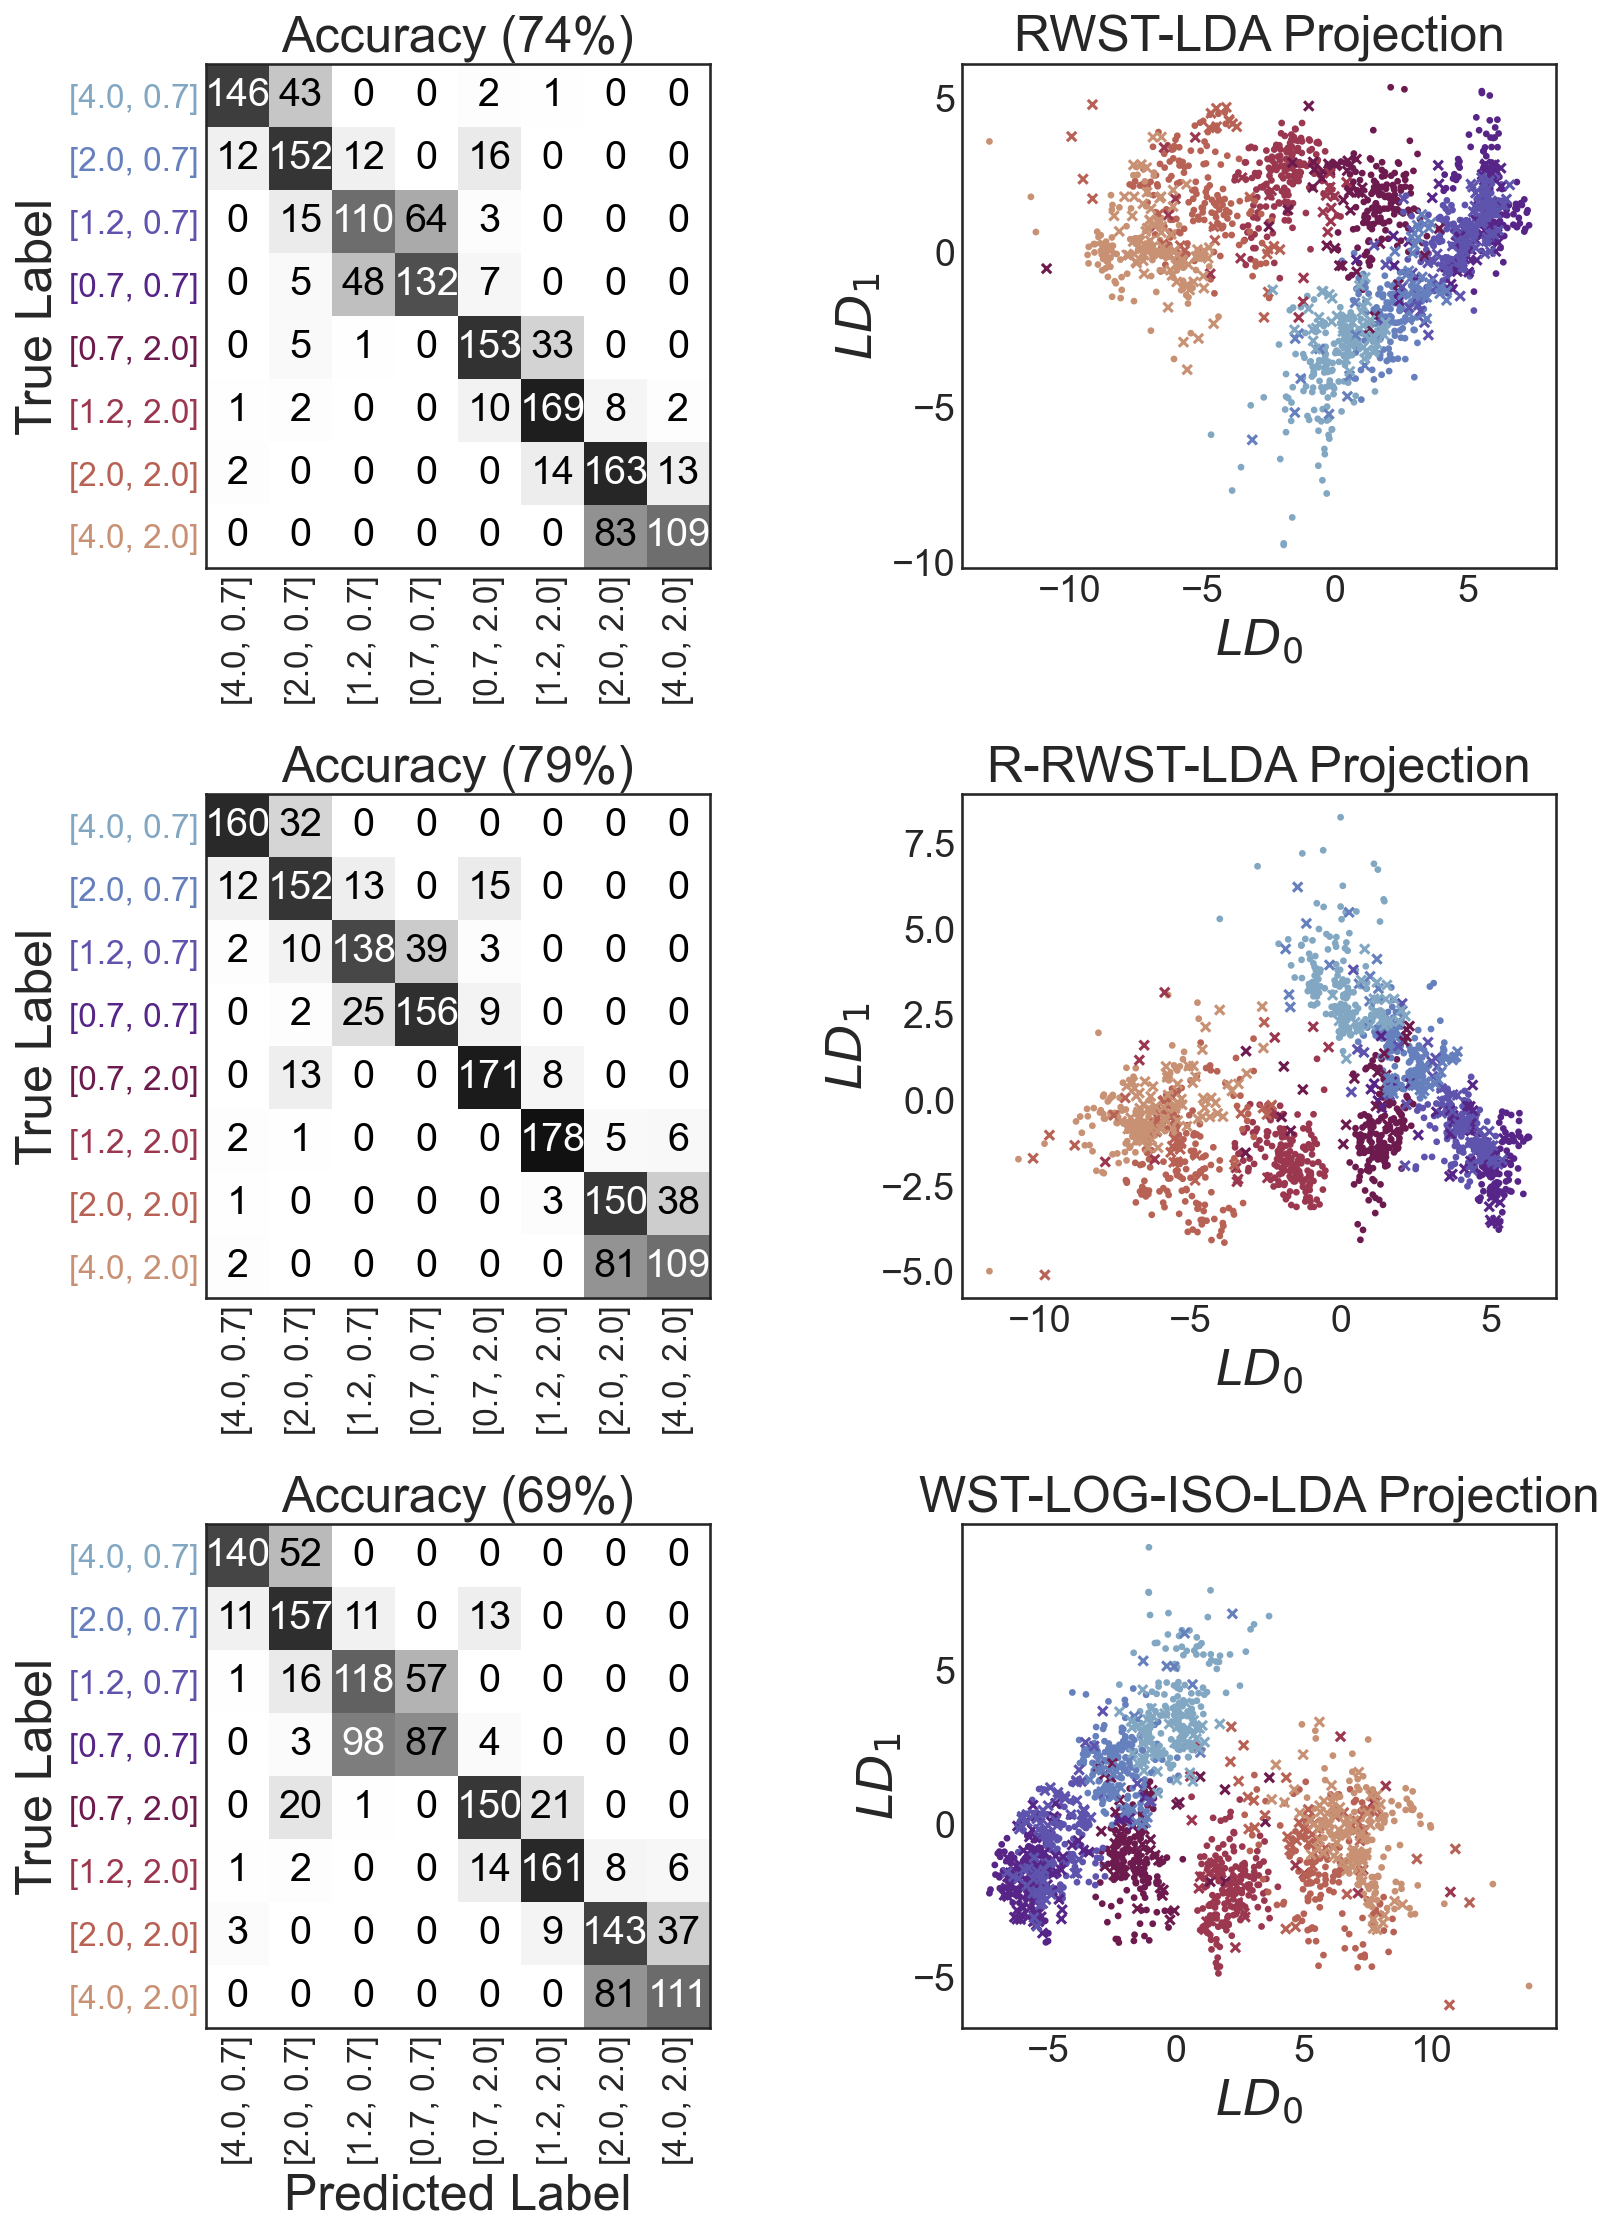

In [82]:
#
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 24
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')

y_predR = (y_predR-4.5)
y_predR[y_predR<0] = y_predR[y_predR<0] - 1
y_predR[y_predR>0] = y_predR[y_predR>0] + 1

Y_train = (Y_train-4.5)
Y_train[Y_train<0] = Y_train[Y_train<0] - 1
Y_train[Y_train>0] = Y_train[Y_train>0] + 1

Y_testR = (Y_testR-4.5)
Y_testR[Y_testR<0] = Y_testR[Y_testR<0] - 1
Y_testR[Y_testR>0] = Y_testR[Y_testR>0] + 1


y_predRR = (y_predRR-4.5)
y_predRR[y_predRR<0] = y_predRR[y_predRR<0] - 1
y_predRR[y_predRR>0] = y_predRR[y_predRR>0] + 1

Y_testRR = (Y_testRR-4.5)
Y_testRR[Y_testRR<0] = Y_testRR[Y_testRR<0] - 1
Y_testRR[Y_testRR>0] = Y_testRR[Y_testRR>0] + 1


y_predW = (y_predW-4.5)
y_predW[y_predW<0] = y_predW[y_predW<0] - 1
y_predW[y_predW>0] = y_predW[y_predW>0] + 1

Y_testW = (Y_testW-4.5)
Y_testW[Y_testW<0] = Y_testW[Y_testW<0] - 1
Y_testW[Y_testW>0] = Y_testW[Y_testW>0] + 1

vmin=Y_train.min()-2
vmax=Y_train.max()+2
marker_size = 10
label_list = labels

from matplotlib import cm as cmplt
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
rgba_colors = [cmplt.twilight(norm(i)) for indx, i in enumerate(np.unique(Y_testR))]
color_order = ["white","black"]
color_map = "binary"
colormap='twilight'

fig = plt.figure(figsize=(12,17),dpi=150)

ax = fig.add_subplot(3,2,1)
ax.imshow(cmap_normalR,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1
)

ax.set_xticks(np.arange(cmR.shape[0]))
ax.set_yticks(np.arange(cmR.shape[1]))

ax.set_xticklabels(label_list,size=16)
ax.set_yticklabels(label_list,size=16)

for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
    ytick.set_color(color)

#plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
         rotation_mode="anchor")
plt.title('Accuracy ({:.0f}%)'.format(100*precR))

# Loop over data dimensions and create text annotations.
textcolors=color_order
threshold = 0.5
for i in range(cmR.shape[0]):
    for j in range(cmR.shape[1]):
        text = ax.text(j, i, cmR[i, j],
                       ha="center", va="center",
                       size=19,
                       color=textcolors[int(cmap_normalR[i, j] < threshold)])
for i in range(2,3):
    ax = fig.add_subplot(3,2,i)
    #ax.scatter(X_train[:,i-2], X_train[:,i-1], s=marker_size/2, marker='o', zorder=10,c=y_train, cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    sc_ref = ax.scatter(X_testR[Y_testR==y_predR,i-2], X_testR[Y_testR==y_predR,i-1], s=marker_size/2, marker='o', zorder=10,c=Y_testR[Y_testR==y_predR], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    ax.scatter(X_testR[Y_testR!=y_predR,i-2], X_testR[Y_testR!=y_predR,i-1], s=marker_size*2, marker='x', zorder=10,c=Y_testR[Y_testR!=y_predR], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)

    plt.xlabel('$LD_{}$'.format(i-2))
    plt.ylabel('$LD_{}$'.format(i-1))
    plt.title('RWST-LDA Projection')

ax = fig.add_subplot(3,2,3)
ax.imshow(cmap_normalRR,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1
)

ax.set_xticks(np.arange(cmRR.shape[0]))
ax.set_yticks(np.arange(cmRR.shape[1]))

ax.set_xticklabels(label_list,size=16)
ax.set_yticklabels(label_list,size=16)

for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
    ytick.set_color(color)

#plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
         rotation_mode="anchor")
plt.title('Accuracy ({:.0f}%)'.format(100*precRR))

# Loop over data dimensions and create text annotations.
textcolors=color_order
threshold = 0.5
for i in range(cmRR.shape[0]):
    for j in range(cmRR
                   .shape[1]):
        text = ax.text(j, i, cmRR[i, j],
                       ha="center", va="center",
                       size=19,
                       color=textcolors[int(cmap_normalRR[i, j] < threshold)])
for i in range(2,3):
    ax = fig.add_subplot(3,2,2+i)
    #ax.scatter(X_train_1[:,i-2], X_train_1[:,i-1], s=marker_size/2, marker='o', zorder=10,c=y_train_1, cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    sc_ref = ax.scatter(X_testRR[Y_testRR==y_predRR,i-2], X_testRR[Y_testRR==y_predRR,i-1], s=marker_size/2, marker='o', zorder=10,c=Y_testRR[Y_testRR==y_predRR], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    ax.scatter(X_testRR[Y_testRR!=y_predRR,i-2], X_testRR[Y_testRR!=y_predRR,i-1], s=marker_size*2, marker='x', zorder=10,c=Y_testRR[Y_testRR!=y_predRR], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)

    plt.xlabel('$LD_{}$'.format(i-2))
    plt.ylabel('$LD_{}$'.format(i-1))
    plt.title('R-RWST-LDA Projection')
    
#     if i == 2:
#         plt.xlim(-12,12)
#         plt.ylim(-12,12)
#     else:
#         plt.xlim(-12,12)
#         plt.ylim(-6,6)

ax = fig.add_subplot(3,2,5)
ax.imshow(cmap_normalW,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1
)

ax.set_xticks(np.arange(cmW.shape[0]))
ax.set_yticks(np.arange(cmW.shape[1]))

ax.set_xticklabels(label_list,size=16)
ax.set_yticklabels(label_list,size=16)

for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
    ytick.set_color(color)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
         rotation_mode="anchor")
plt.title('Accuracy ({:.0f}%)'.format(100*precW))

# Loop over data dimensions and create text annotations.
textcolors=color_order
threshold = 0.5
for i in range(cmW.shape[0]):
    for j in range(cmW.shape[1]):
        text = ax.text(j, i, cmW[i, j],
                       ha="center", va="center",
                       size=19,
                       color=textcolors[int(cmap_normalW[i, j] < threshold)])
for i in range(2,3):
    ax = fig.add_subplot(3,2,4+i)
    #ax.scatter(X_train_2[:,i-2], X_train_2[:,i-1], s=marker_size/2, marker='o', zorder=10,c=y_train_2, cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    sc_ref = ax.scatter(X_testW[Y_testW==y_predW,i-2], X_testW[Y_testW==y_predW,i-1], s=marker_size/2, marker='o', zorder=10,c=Y_testW[Y_testW==y_predW], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    ax.scatter(X_testW[Y_testW!=y_predW,i-2], X_testW[Y_testW!=y_predW,i-1], s=marker_size*2, marker='x', zorder=10,c=Y_testW[Y_testW!=y_predW], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)

    plt.xlabel('$LD_{}$'.format(i-2))
    plt.ylabel('$LD_{}$'.format(i-1))
    plt.title('WST-LOG-ISO-LDA Projection')
    
fig.subplots_adjust(wspace=0.35, hspace=0.45)
plt.savefig('../figures/RWSTCompare.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [73]:
with open('../../DHC/from_cannon/2021_04_04/RWST_MHD_rinvar_cumsum_apod.p', 'rb') as input_file:
    RWST_MHD_rinvar_cumsum_apod = np.array(pickle.load(input_file))
    
with open('../../DHC/from_cannon/2021_04_04/WST_MHD_rinvar_cumsum_apod.p', 'rb') as input_file:
    WST_MHD_rinvar_cumsum_apod = np.array(pickle.load(input_file))
    
WST_MHD_rinvar_cumsum_log_iso_apod = np.array([WST_log_iso(WST_MHD_rinvar_cumsum_apod[i,:]) for i in range(6912)])

In [79]:
#
data = RWST_MHD_rinvar_cumsum_apod
label = wph_2dcs_labels
labels = [[4.0,0.7],[2.0,0.7],[1.2,0.7],[0.7,0.7],[0.7,2.0],[1.2,2.0],[2.0,2.0],[4.0,2.0]]

train = [~np.isin(ele[lbl["t"]],[600,900]) for ele in label]
test = [np.isin(ele[lbl["t"]],[600,900]) for ele in label]
Y = label[:,lbl["class"]]

sc = StandardScaler()
X_train = sc.fit_transform(np.arcsinh(data[train]/(1e-20)))
X_test = sc.transform(np.arcsinh(data[test]/(1e-20)))
Y_train = Y[train]
Y_testR = Y[test]

lda = LDA(n_components=7)
X_train = lda.fit_transform(X_train, Y_train)
y_predR = lda.predict(X_test)
X_testR = lda.transform(X_test)
cmR = confusion_matrix(Y_testR, y_predR)
precR = precision_score(Y_testR, y_predR,average='micro')
cmap_normalR = (cmR.T/cmR.sum(axis=1)).T

data = RWST_MHD_rinvar_cumsum_apod[:,np.concatenate((offset_1,offset_2))]
label = wph_2dcs_labels

train = [~np.isin(ele[lbl["t"]],[600,900]) for ele in label]
test = [np.isin(ele[lbl["t"]],[600,900]) for ele in label]
Y = label[:,lbl["class"]]

sc = StandardScaler()
X_train = sc.fit_transform(np.arcsinh(data[train]/(1e-20)))
X_test = sc.transform(np.arcsinh(data[test]/(1e-20)))
Y_train = Y[train]
Y_testRR = Y[test]

lda = LDA(n_components=7)
X_train = lda.fit_transform(X_train, Y_train)
y_predRR = lda.predict(X_test)
X_testRR = lda.transform(X_test)
cmRR = confusion_matrix(Y_testRR, y_predRR)
precRR = precision_score(Y_testRR, y_predRR,average='micro')
cmap_normalRR = (cmRR.T/cmRR.sum(axis=1)).T

data = WST_MHD_rinvar_cumsum_log_iso_apod
label = wph_2dcs_labels

train = [~np.isin(ele[lbl["t"]],[600,900]) for ele in label]
test = [np.isin(ele[lbl["t"]],[600,900]) for ele in label]
Y = label[:,lbl["class"]]

sc = StandardScaler()
X_train = sc.fit_transform(np.arcsinh(data[train]/(1e-20)))
X_test = sc.transform(np.arcsinh(data[test]/(1e-20)))
Y_train = Y[train]
Y_testW = Y[test]

lda = LDA(n_components=7)
X_train = lda.fit_transform(X_train, Y_train)
y_predW = lda.predict(X_test)
X_testW = lda.transform(X_test)
cmW = confusion_matrix(Y_testW, y_predW)
precW = precision_score(Y_testW, y_predW,average='micro')
cmap_normalW = (cmW.T/cmW.sum(axis=1)).T

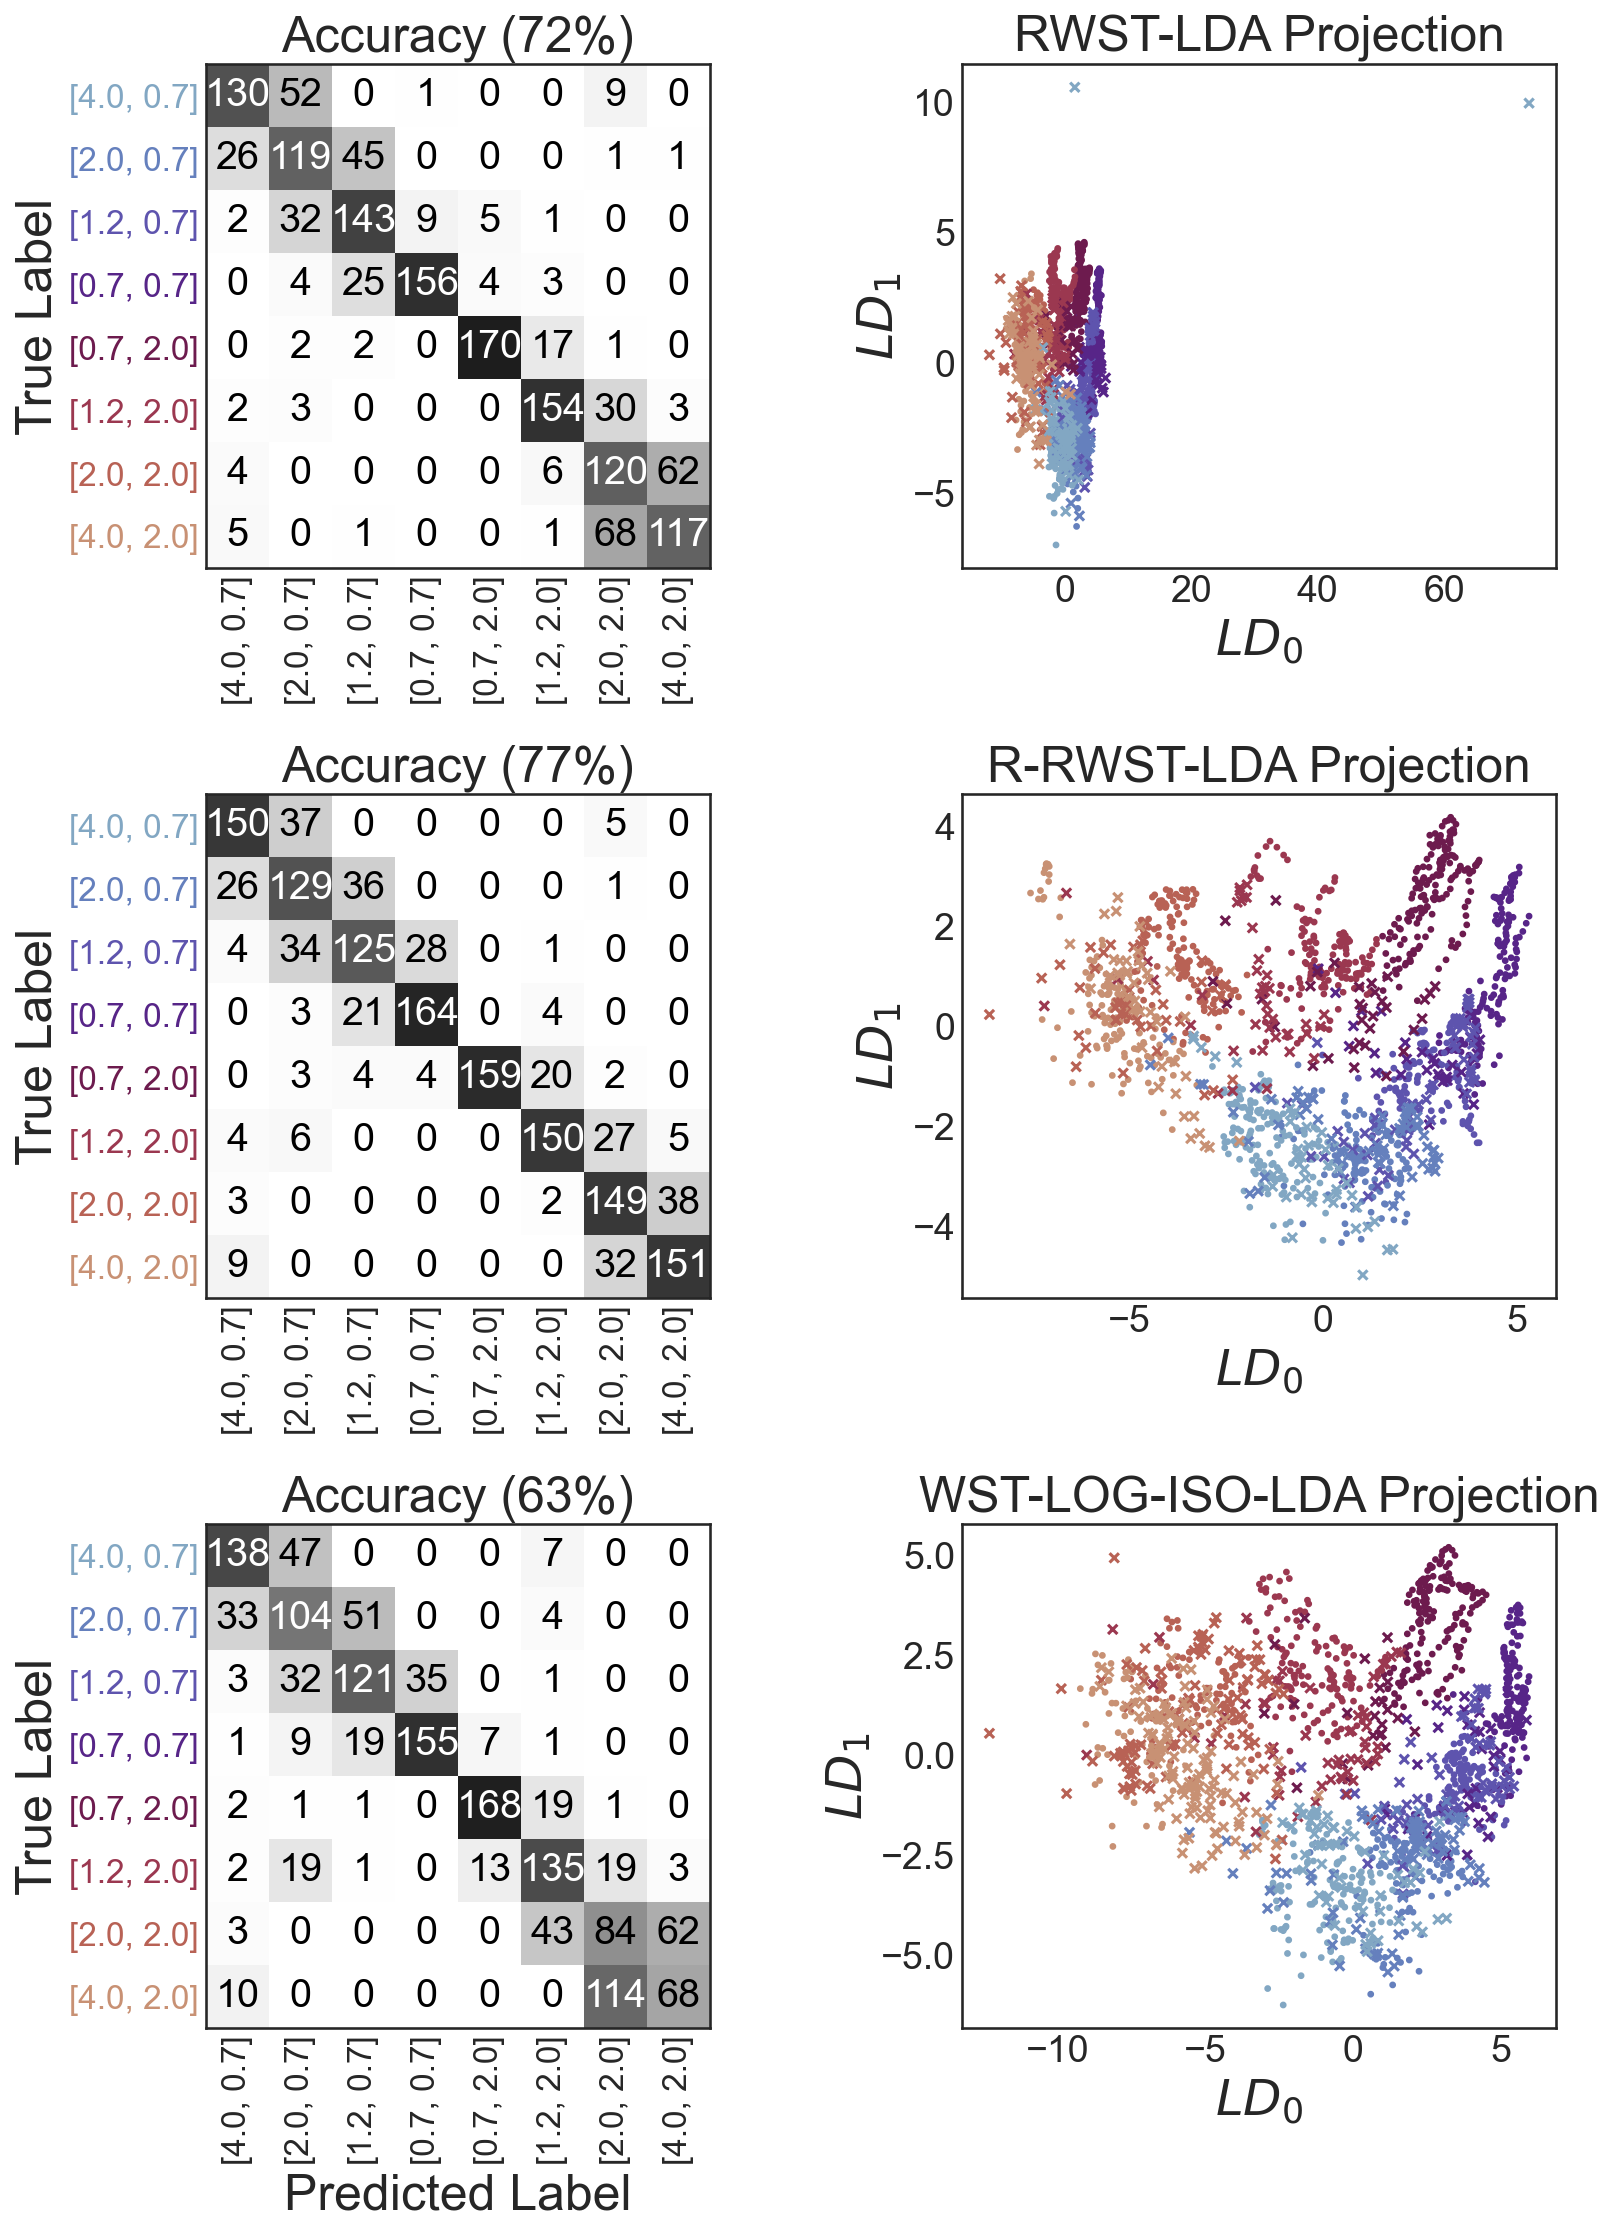

In [80]:
#
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 24
rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-white')

y_predR = (y_predR-4.5)
y_predR[y_predR<0] = y_predR[y_predR<0] - 1
y_predR[y_predR>0] = y_predR[y_predR>0] + 1

Y_train = (Y_train-4.5)
Y_train[Y_train<0] = Y_train[Y_train<0] - 1
Y_train[Y_train>0] = Y_train[Y_train>0] + 1

Y_testR = (Y_testR-4.5)
Y_testR[Y_testR<0] = Y_testR[Y_testR<0] - 1
Y_testR[Y_testR>0] = Y_testR[Y_testR>0] + 1


y_predRR = (y_predRR-4.5)
y_predRR[y_predRR<0] = y_predRR[y_predRR<0] - 1
y_predRR[y_predRR>0] = y_predRR[y_predRR>0] + 1

Y_testRR = (Y_testRR-4.5)
Y_testRR[Y_testRR<0] = Y_testRR[Y_testRR<0] - 1
Y_testRR[Y_testRR>0] = Y_testRR[Y_testRR>0] + 1


y_predW = (y_predW-4.5)
y_predW[y_predW<0] = y_predW[y_predW<0] - 1
y_predW[y_predW>0] = y_predW[y_predW>0] + 1

Y_testW = (Y_testW-4.5)
Y_testW[Y_testW<0] = Y_testW[Y_testW<0] - 1
Y_testW[Y_testW>0] = Y_testW[Y_testW>0] + 1

vmin=Y_train.min()-2
vmax=Y_train.max()+2
marker_size = 10
label_list = labels

from matplotlib import cm as cmplt
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
rgba_colors = [cmplt.twilight(norm(i)) for indx, i in enumerate(np.unique(Y_testR))]
color_order = ["white","black"]
color_map = "binary"
colormap='twilight'

fig = plt.figure(figsize=(12,17),dpi=150)

ax = fig.add_subplot(3,2,1)
ax.imshow(cmap_normalR,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1
)

ax.set_xticks(np.arange(cmR.shape[0]))
ax.set_yticks(np.arange(cmR.shape[1]))

ax.set_xticklabels(label_list,size=16)
ax.set_yticklabels(label_list,size=16)

for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
    ytick.set_color(color)

#plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
         rotation_mode="anchor")
plt.title('Accuracy ({:.0f}%)'.format(100*precR))

# Loop over data dimensions and create text annotations.
textcolors=color_order
threshold = 0.5
for i in range(cmR.shape[0]):
    for j in range(cmR.shape[1]):
        text = ax.text(j, i, cmR[i, j],
                       ha="center", va="center",
                       size=19,
                       color=textcolors[int(cmap_normalR[i, j] < threshold)])
for i in range(2,3):
    ax = fig.add_subplot(3,2,i)
    #ax.scatter(X_train[:,i-2], X_train[:,i-1], s=marker_size/2, marker='o', zorder=10,c=y_train, cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    sc_ref = ax.scatter(X_testR[Y_testR==y_predR,i-2], X_testR[Y_testR==y_predR,i-1], s=marker_size/2, marker='o', zorder=10,c=Y_testR[Y_testR==y_predR], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    ax.scatter(X_testR[Y_testR!=y_predR,i-2], X_testR[Y_testR!=y_predR,i-1], s=marker_size*2, marker='x', zorder=10,c=Y_testR[Y_testR!=y_predR], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)

    plt.xlabel('$LD_{}$'.format(i-2))
    plt.ylabel('$LD_{}$'.format(i-1))
    plt.title('RWST-LDA Projection')

ax = fig.add_subplot(3,2,3)
ax.imshow(cmap_normalRR,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1
)

ax.set_xticks(np.arange(cmRR.shape[0]))
ax.set_yticks(np.arange(cmRR.shape[1]))

ax.set_xticklabels(label_list,size=16)
ax.set_yticklabels(label_list,size=16)

for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
    ytick.set_color(color)

#plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
         rotation_mode="anchor")
plt.title('Accuracy ({:.0f}%)'.format(100*precRR))

# Loop over data dimensions and create text annotations.
textcolors=color_order
threshold = 0.5
for i in range(cmRR.shape[0]):
    for j in range(cmRR
                   .shape[1]):
        text = ax.text(j, i, cmRR[i, j],
                       ha="center", va="center",
                       size=19,
                       color=textcolors[int(cmap_normalRR[i, j] < threshold)])
for i in range(2,3):
    ax = fig.add_subplot(3,2,2+i)
    #ax.scatter(X_train_1[:,i-2], X_train_1[:,i-1], s=marker_size/2, marker='o', zorder=10,c=y_train_1, cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    sc_ref = ax.scatter(X_testRR[Y_testRR==y_predRR,i-2], X_testRR[Y_testRR==y_predRR,i-1], s=marker_size/2, marker='o', zorder=10,c=Y_testRR[Y_testRR==y_predRR], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    ax.scatter(X_testRR[Y_testRR!=y_predRR,i-2], X_testRR[Y_testRR!=y_predRR,i-1], s=marker_size*2, marker='x', zorder=10,c=Y_testRR[Y_testRR!=y_predRR], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)

    plt.xlabel('$LD_{}$'.format(i-2))
    plt.ylabel('$LD_{}$'.format(i-1))
    plt.title('R-RWST-LDA Projection')
    
#     if i == 2:
#         plt.xlim(-12,12)
#         plt.ylim(-12,12)
#     else:
#         plt.xlim(-12,12)
#         plt.ylim(-6,6)

ax = fig.add_subplot(3,2,5)
ax.imshow(cmap_normalW,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1
)

ax.set_xticks(np.arange(cmW.shape[0]))
ax.set_yticks(np.arange(cmW.shape[1]))

ax.set_xticklabels(label_list,size=16)
ax.set_yticklabels(label_list,size=16)

for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
    ytick.set_color(color)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
         rotation_mode="anchor")
plt.title('Accuracy ({:.0f}%)'.format(100*precW))

# Loop over data dimensions and create text annotations.
textcolors=color_order
threshold = 0.5
for i in range(cmW.shape[0]):
    for j in range(cmW.shape[1]):
        text = ax.text(j, i, cmW[i, j],
                       ha="center", va="center",
                       size=19,
                       color=textcolors[int(cmap_normalW[i, j] < threshold)])
for i in range(2,3):
    ax = fig.add_subplot(3,2,4+i)
    #ax.scatter(X_train_2[:,i-2], X_train_2[:,i-1], s=marker_size/2, marker='o', zorder=10,c=y_train_2, cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    sc_ref = ax.scatter(X_testW[Y_testW==y_predW,i-2], X_testW[Y_testW==y_predW,i-1], s=marker_size/2, marker='o', zorder=10,c=Y_testW[Y_testW==y_predW], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)
    ax.scatter(X_testW[Y_testW!=y_predW,i-2], X_testW[Y_testW!=y_predW,i-1], s=marker_size*2, marker='x', zorder=10,c=Y_testW[Y_testW!=y_predW], cmap = colormap, vmin=vmin,vmax=vmax,alpha=1)

    plt.xlabel('$LD_{}$'.format(i-2))
    plt.ylabel('$LD_{}$'.format(i-1))
    plt.title('WST-LOG-ISO-LDA Projection')
    
fig.subplots_adjust(wspace=0.35, hspace=0.45)
#plt.savefig('../figures/RWSTCompare.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

Triple Check ISO index order plot

In [164]:
def DHC_iso_S2(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.transpose(np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1))),(0,2,1))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return S2iso.reshape(nk,int(J*J*L))

In [165]:
test_iso2 = DHC_iso_S2(test,J,L)

In [169]:
J = 6
L = 8
# length_out = np.sum(drop_out_mean,axis=1)
# temp_out = length_out[J+3:J+3+J*J*L].reshape(J,J,L)

In [230]:
test = np.zeros((1,J*L+3+(J*L+1)*(J*L+1)))
for j1 in range(6):
    for j2 in range(6):
        for l1 in range(8):
            for l2 in range(8):
                test[:,J*L+3+(j1+l1*6)+(j2+l2*6)*(J*L+1)] = np.abs(np.mod(l1-l2,L))

In [231]:
def DHC_iso_all(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.transpose(np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1))),(0,2,1))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,int(J*J*L)),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [232]:
test_iso = DHC_iso_all(test,J,L)

In [233]:
test_iso.shape

(1, 310)

In [234]:
np.max(test_iso), np.max(test)

(56.0, 7.0)

In [235]:
J = 6
L = 8
length_out = test_iso.reshape(310)
temp_out = length_out[J+3:J+3+J*J*L].reshape(J,J,L)

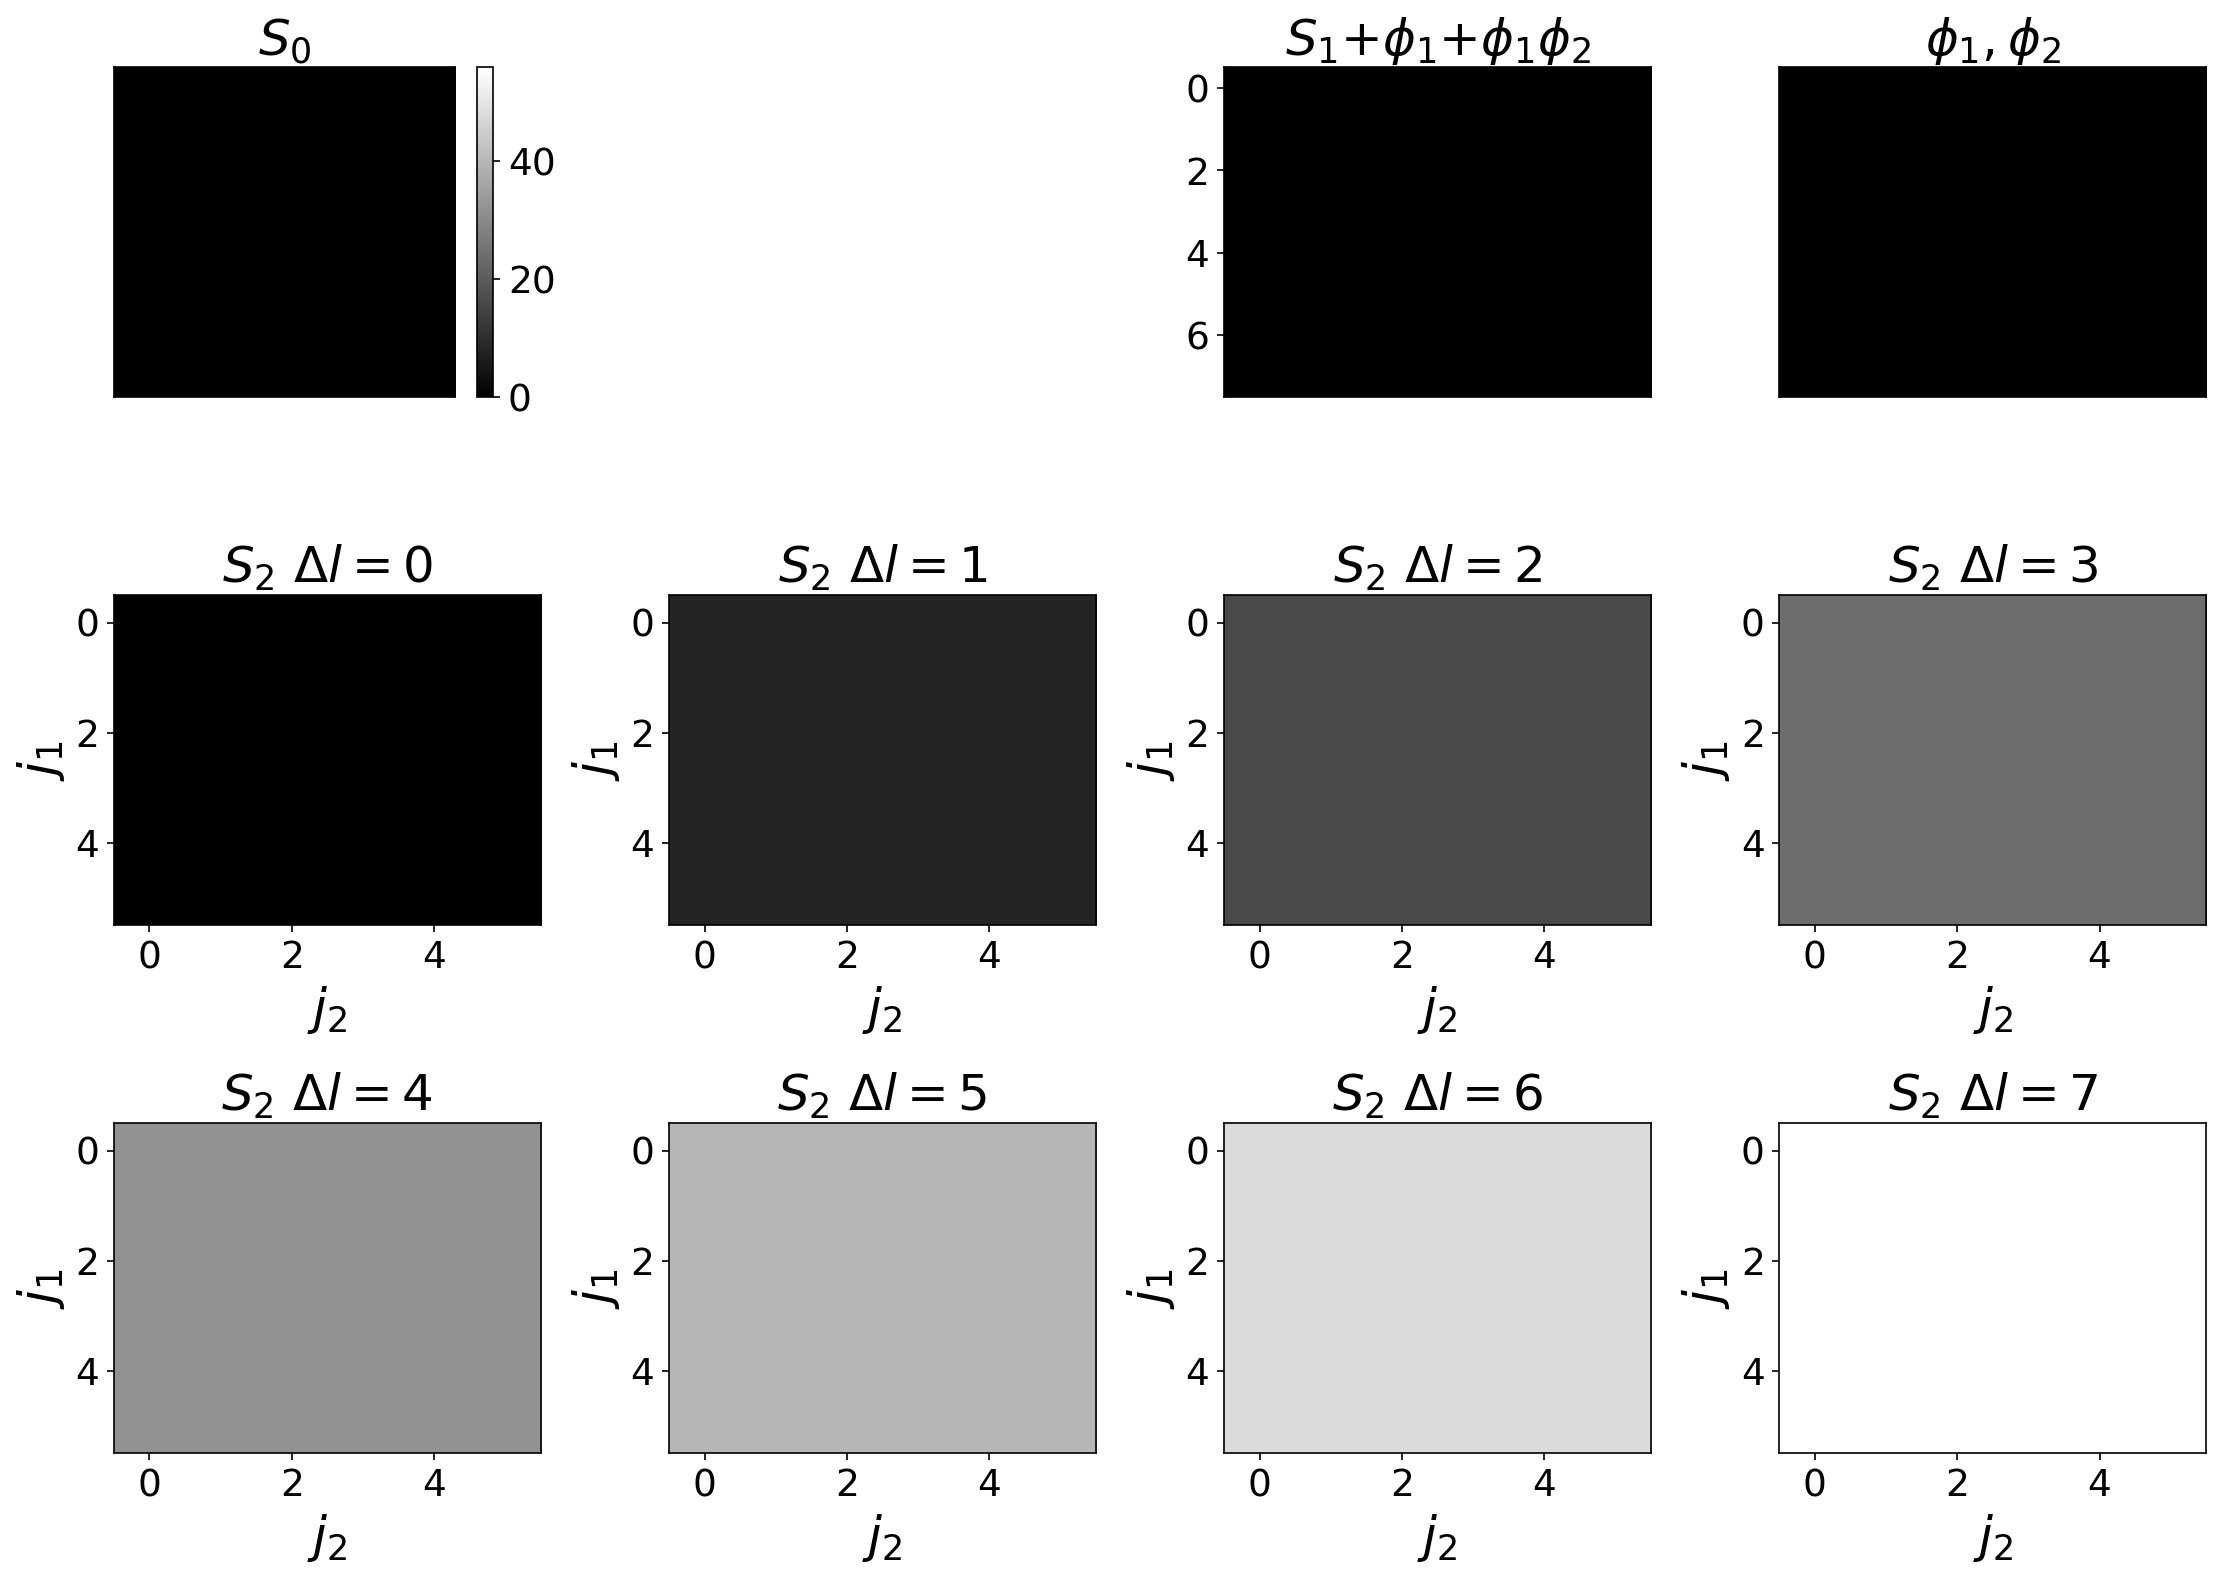

In [236]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 24
rcParams['font.family'] = 'sans-serif'

fig = plt.figure(figsize=(18,12),dpi=150)
ax = fig.add_subplot(3,4,1)    
im = ax.imshow(length_out[0:2].reshape(2,1),
         aspect='auto',
         cmap='gray',
         vmin = 0,
         vmax = np.max(test_iso))

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$S_0$')
plt.colorbar(im)

J=6
ax = fig.add_subplot(3,4,3)    
im = ax.imshow(np.append(length_out[2:J+3],length_out[-1]).reshape(J+2,1),
         aspect='auto',
         cmap='gray',
         vmin = 0,
         vmax = np.max(test_iso))

plt.title('$S_1$+$\phi_1$+$\phi_1 \phi_2$')
ax.axes.xaxis.set_ticks([])

J=6
L=8

for i in range(L):
    ax = fig.add_subplot(3,4,5+i)    
    im = ax.imshow(temp_out[:,:,i],
             aspect='auto',
             cmap='gray',
             vmin = 0,
             vmax = np.max(test_iso))

    plt.xlabel('$j_2$')
    plt.ylabel('$j_1$')
    plt.title('$S_2$ $\Delta l = {}$'.format(i))

ax = fig.add_subplot(3,4,4)    
im = ax.imshow(length_out[J+3+J*J*L:J+3+J*J*L+2*J].reshape(2,J),
         aspect='auto',
         cmap='gray',
         vmin = 0,
         vmax = np.max(test_iso))

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$\phi_1, \phi_2$')

fig.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

In [136]:
testISO = hd5_open('../scratch_AKS/data/isoPlotTest.h5','data')

In [137]:
J = 6
L = 8
length_out = testISO.reshape(310)
temp_out = length_out[J+3:J+3+J*J*L].reshape(J,J,L)

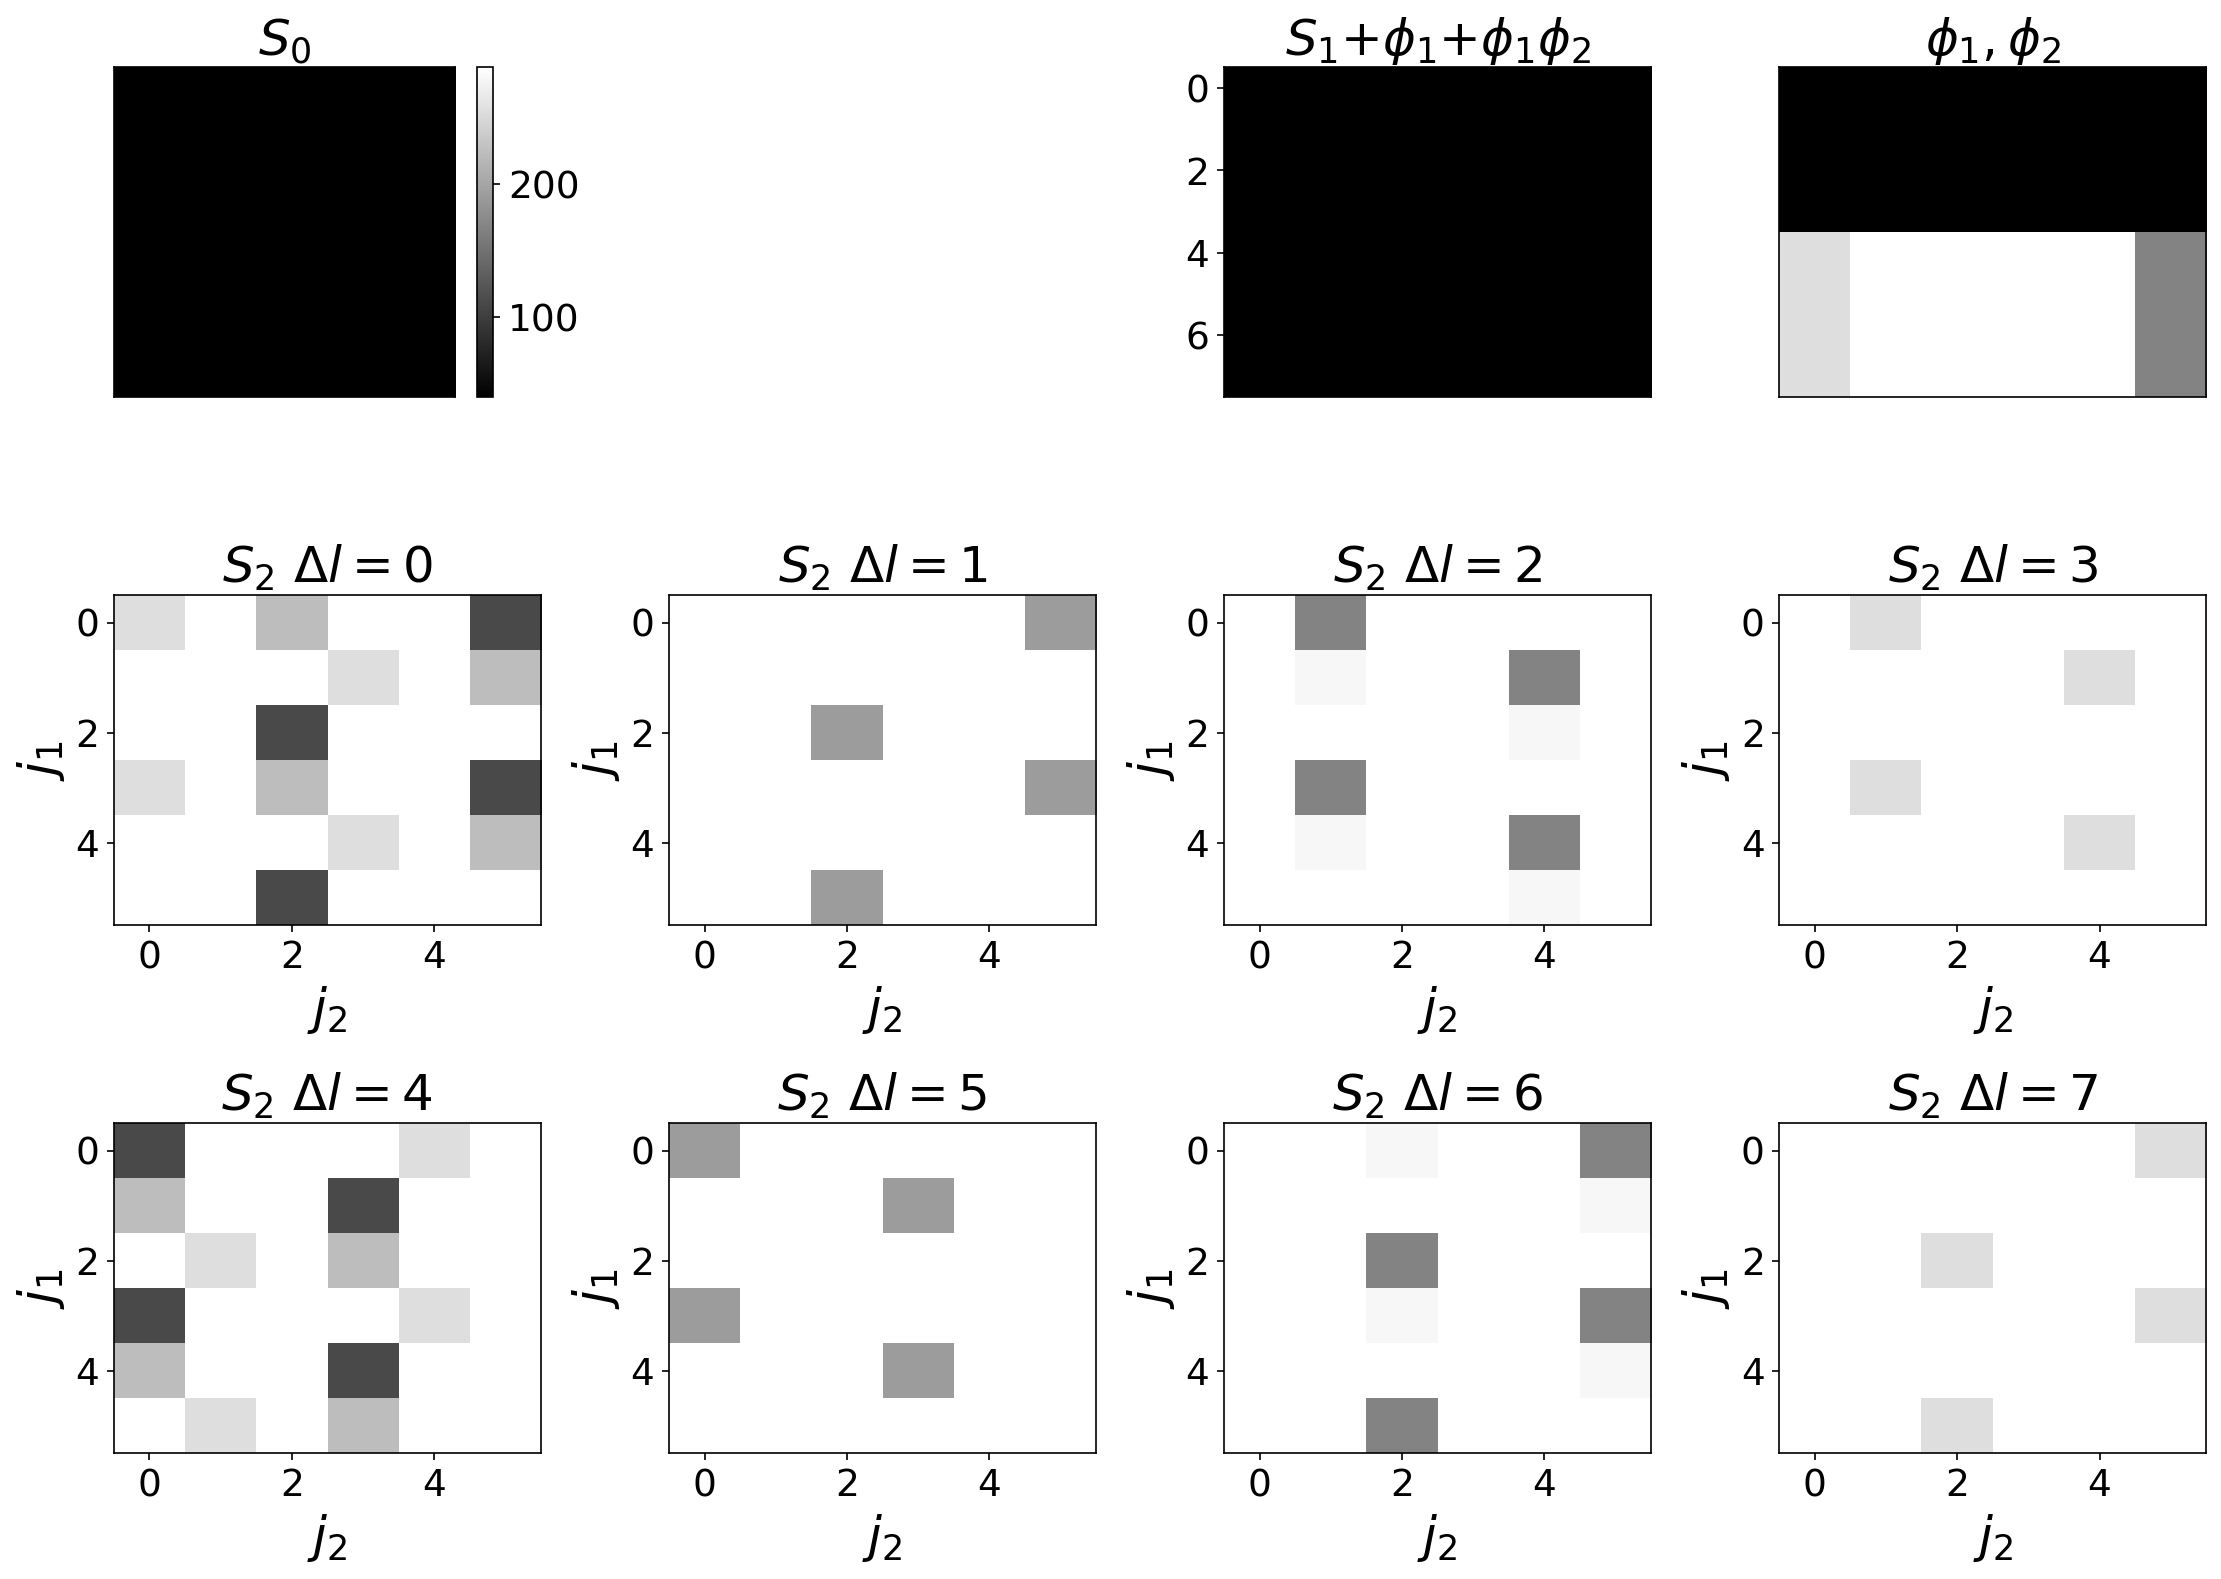

In [138]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 24
rcParams['font.family'] = 'sans-serif'

fig = plt.figure(figsize=(18,12),dpi=150)
ax = fig.add_subplot(3,4,1)    
im = ax.imshow(length_out[0:2].reshape(2,1),
         aspect='auto',
         cmap='gray',
         vmin = 40,
         vmax = 288)

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$S_0$')
plt.colorbar(im)

J=6
ax = fig.add_subplot(3,4,3)    
im = ax.imshow(np.append(length_out[2:J+3],length_out[-1]).reshape(J+2,1),
         aspect='auto',
         cmap='gray',
         vmin = 40,
         vmax = 288)

plt.title('$S_1$+$\phi_1$+$\phi_1 \phi_2$')
ax.axes.xaxis.set_ticks([])

J=6
L=8

for i in range(L):
    ax = fig.add_subplot(3,4,5+i)    
    im = ax.imshow(temp_out[:,:,i],
             aspect='auto',
             cmap='gray',
             vmin = 40,
             vmax = 288)

    plt.xlabel('$j_2$')
    plt.ylabel('$j_1$')
    plt.title('$S_2$ $\Delta l = {}$'.format(i))

ax = fig.add_subplot(3,4,4)    
im = ax.imshow(length_out[J+3+J*J*L:J+3+J*J*L+2*J].reshape(2,J),
         aspect='auto',
         cmap='gray',
         vmin = 40,
         vmax = 288)

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$\phi_1, \phi_2$')

fig.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

In [239]:
rod_test_fluct = hd5_open('../scratch_AKS/paper_data/rod_stable_L8_wd2_N1_noISO.h5','data')

In [240]:
rod_test_fluct.shape

(73, 1724)

In [241]:
angles_std = np.std(rod_test_fluct,axis=0)
angles_mean = np.mean(rod_test_fluct,axis=0)

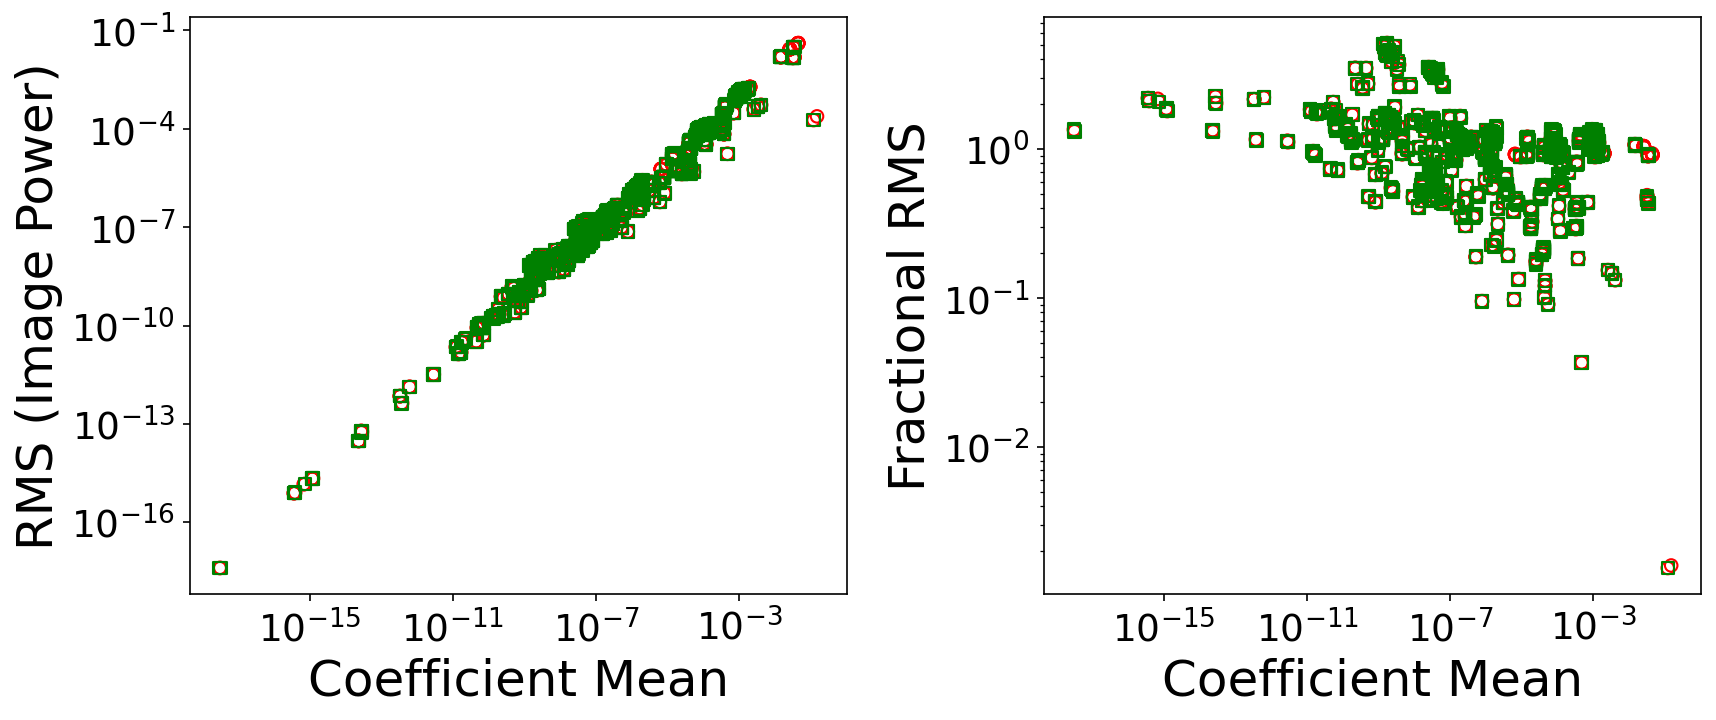

In [256]:
fig = plt.figure(figsize=(13,5), dpi=150)

ax = fig.add_subplot(1,2,1)
ax.scatter(angles_mean[2:],angles_std[2:],marker='o',facecolors='none',edgecolors='r')
ax.scatter(angles_mean[6*8+2:],angles_std[6*8+2::],marker='s',facecolors='none',edgecolors='g')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Coefficient Mean')
plt.ylabel('RMS (Image Power)')

ax = fig.add_subplot(1,2,2)
ax.scatter(angles_mean[2:],angles_std[2:]/angles_mean[2:],marker='o',facecolors='none',edgecolors='r')
ax.scatter(angles_mean[6*8+2:],angles_std[6*8+2::]/angles_mean[6*8+2::],marker='s',facecolors='none',edgecolors='g')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Coefficient Mean')
plt.ylabel('Fractional RMS')

fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [259]:
def DHC_iso_all(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.transpose(np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1))),(0,2,1))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,int(J*J*L)),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [270]:
test_iso2 = DHC_iso_all(rod_test_fluct,5,8)
angles_std_iso = np.std(test_iso2,axis=0)
angles_mean_iso = np.mean(test_iso2,axis=0)

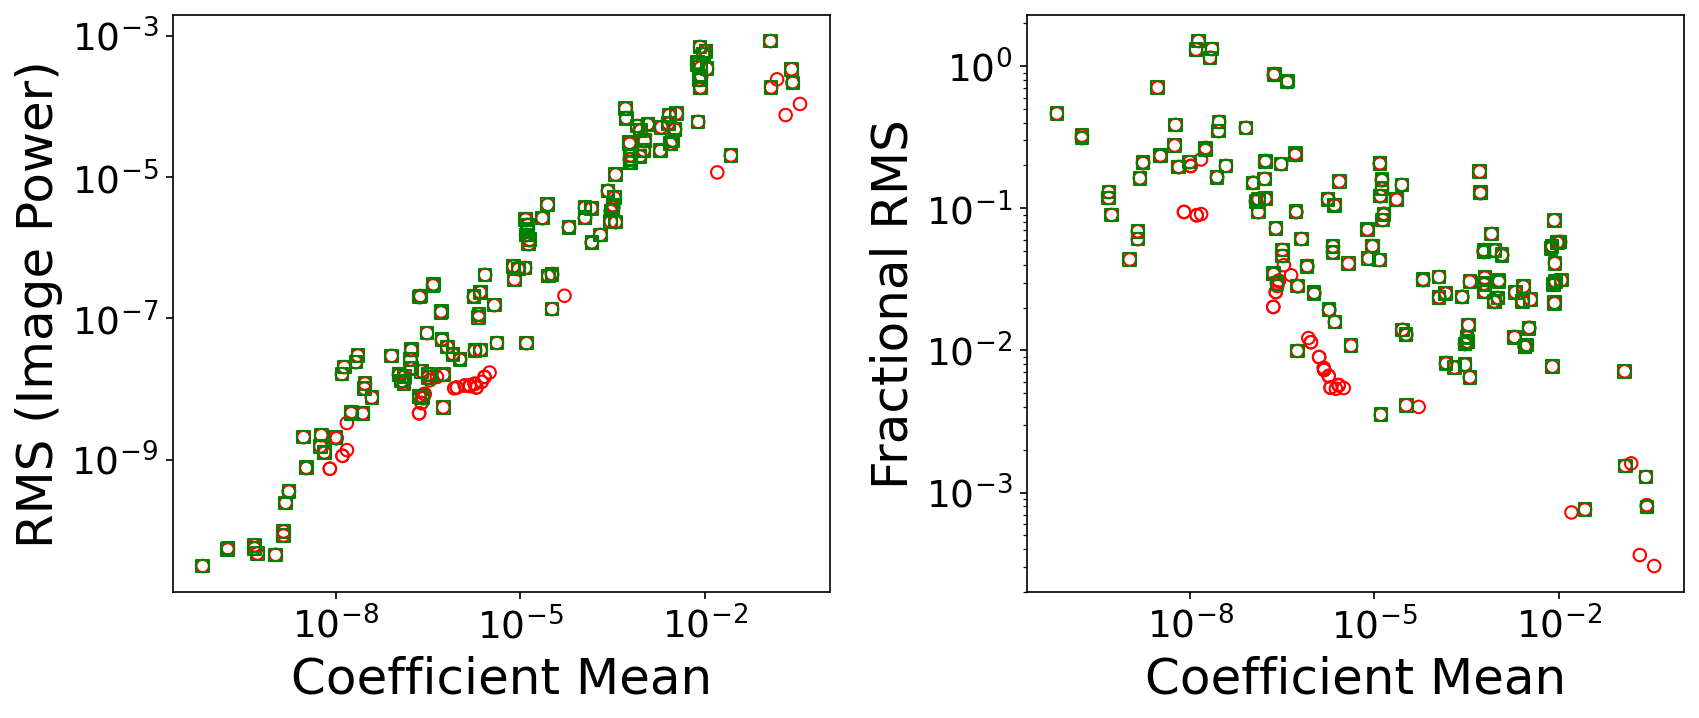

In [277]:
fig = plt.figure(figsize=(13,5), dpi=150)
J=5

ax = fig.add_subplot(1,2,1)
ax.scatter(angles_mean_iso[2:],angles_std_iso[2:],marker='o',facecolors='none',edgecolors='r')
ax.scatter(angles_mean_iso[J*8+2:],angles_std_iso[J*8+2:],marker='s',facecolors='none',edgecolors='g')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Coefficient Mean')
plt.ylabel('RMS (Image Power)')

ax = fig.add_subplot(1,2,2)
ax.scatter(angles_mean_iso[2:],angles_std_iso[2:]/angles_mean_iso[2:],marker='o',facecolors='none',edgecolors='r')
ax.scatter(angles_mean_iso[J*8+2:],angles_std_iso[J*8+2:]/angles_mean_iso[J*8+2:],marker='s',facecolors='none',edgecolors='g')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Coefficient Mean')
plt.ylabel('Fractional RMS')

fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [279]:
J = 5
L = 8
length_out = angles_std_iso.reshape(219)
temp_out = length_out[J+3:J+3+J*J*L].reshape(J,J,L)

In [282]:
data_min = np.nanmin(length_out)
data_max = np.nanmax(length_out)

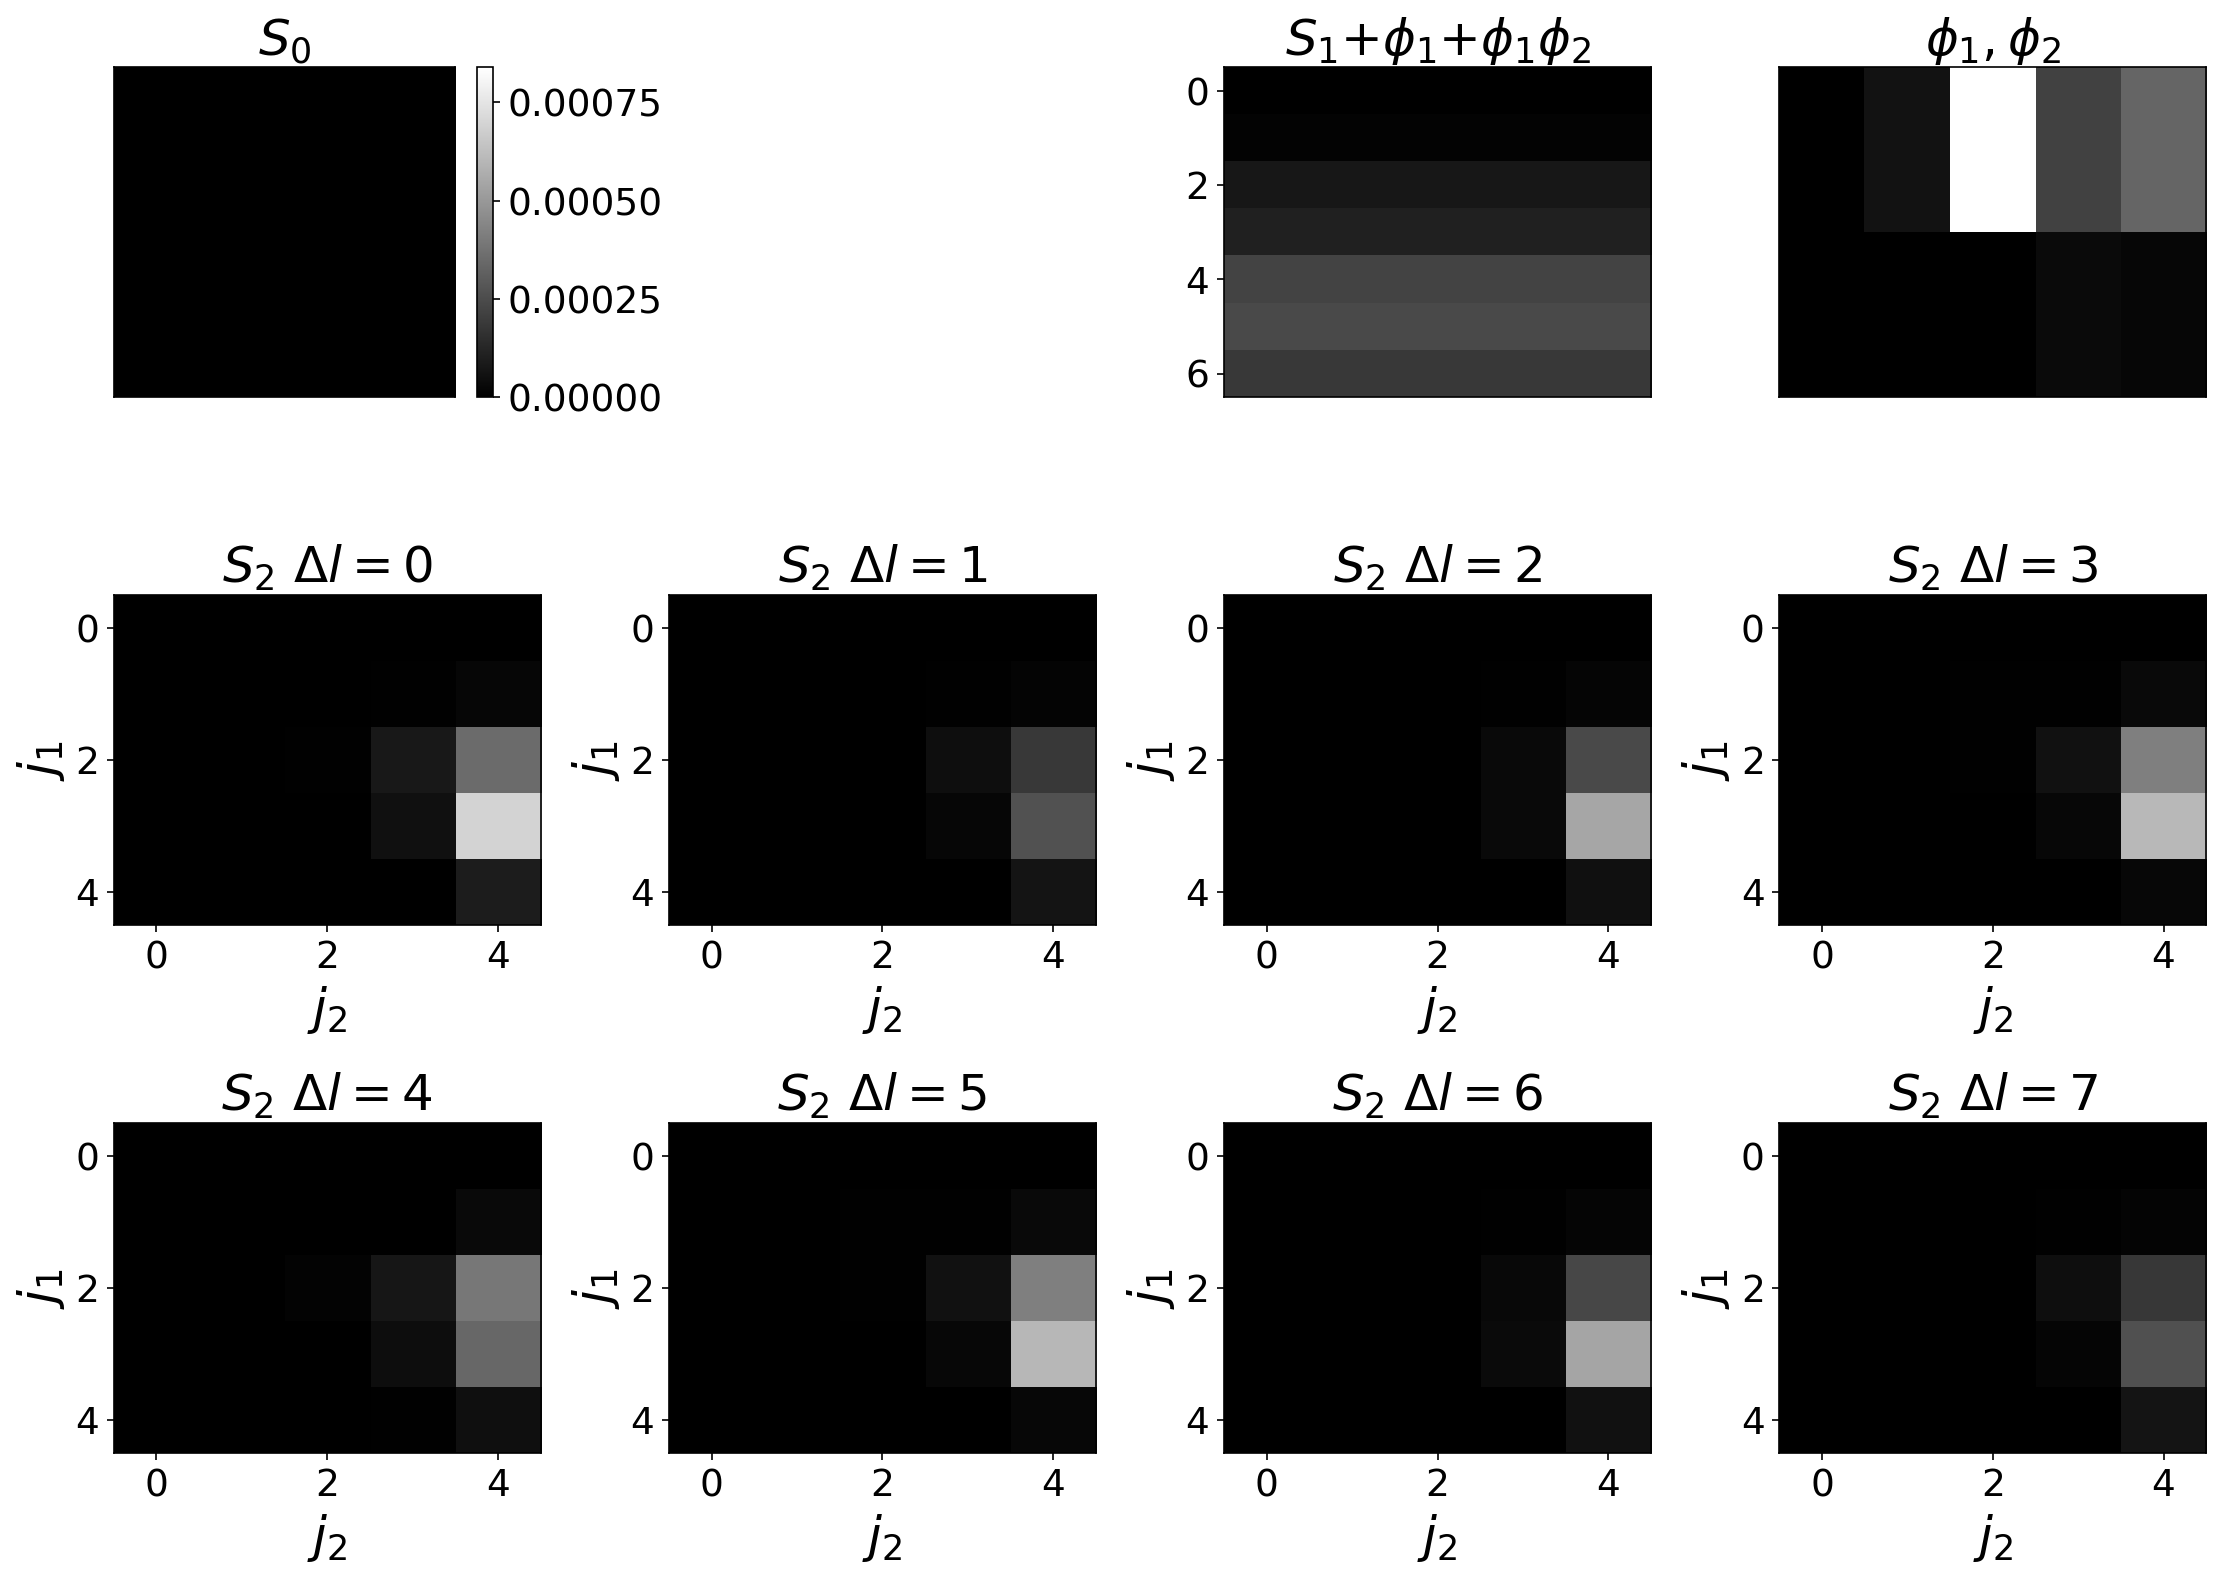

In [284]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 24
rcParams['font.family'] = 'sans-serif'

fig = plt.figure(figsize=(18,12),dpi=150)
ax = fig.add_subplot(3,4,1)    
im = ax.imshow(length_out[0:2].reshape(2,1),
         aspect='auto',
         cmap='gray',
         vmin = data_min,
         vmax = data_max)

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$S_0$')
plt.colorbar(im)

J=5
ax = fig.add_subplot(3,4,3)    
im = ax.imshow(np.append(length_out[2:J+3],length_out[-1]).reshape(J+2,1),
         aspect='auto',
         cmap='gray',
         vmin = data_min,
         vmax = data_max)

plt.title('$S_1$+$\phi_1$+$\phi_1 \phi_2$')
ax.axes.xaxis.set_ticks([])

J=5
L=8

for i in range(L):
    ax = fig.add_subplot(3,4,5+i)    
    im = ax.imshow(temp_out[:,:,i],
             aspect='auto',
             cmap='gray',
             vmin = data_min,
             vmax = data_max)

    plt.xlabel('$j_2$')
    plt.ylabel('$j_1$')
    plt.title('$S_2$ $\Delta l = {}$'.format(i))

ax = fig.add_subplot(3,4,4)    
im = ax.imshow(length_out[J+3+J*J*L:J+3+J*J*L+2*J].reshape(2,J),
         aspect='auto',
         cmap='gray',
         vmin = data_min,
         vmax = data_max)

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$\phi_1, \phi_2$')

fig.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

In [286]:
import matplotlib.colors as colors

In [289]:
data_min = np.nanmin(length_out[2:])
data_max = np.nanmax(length_out[2:])

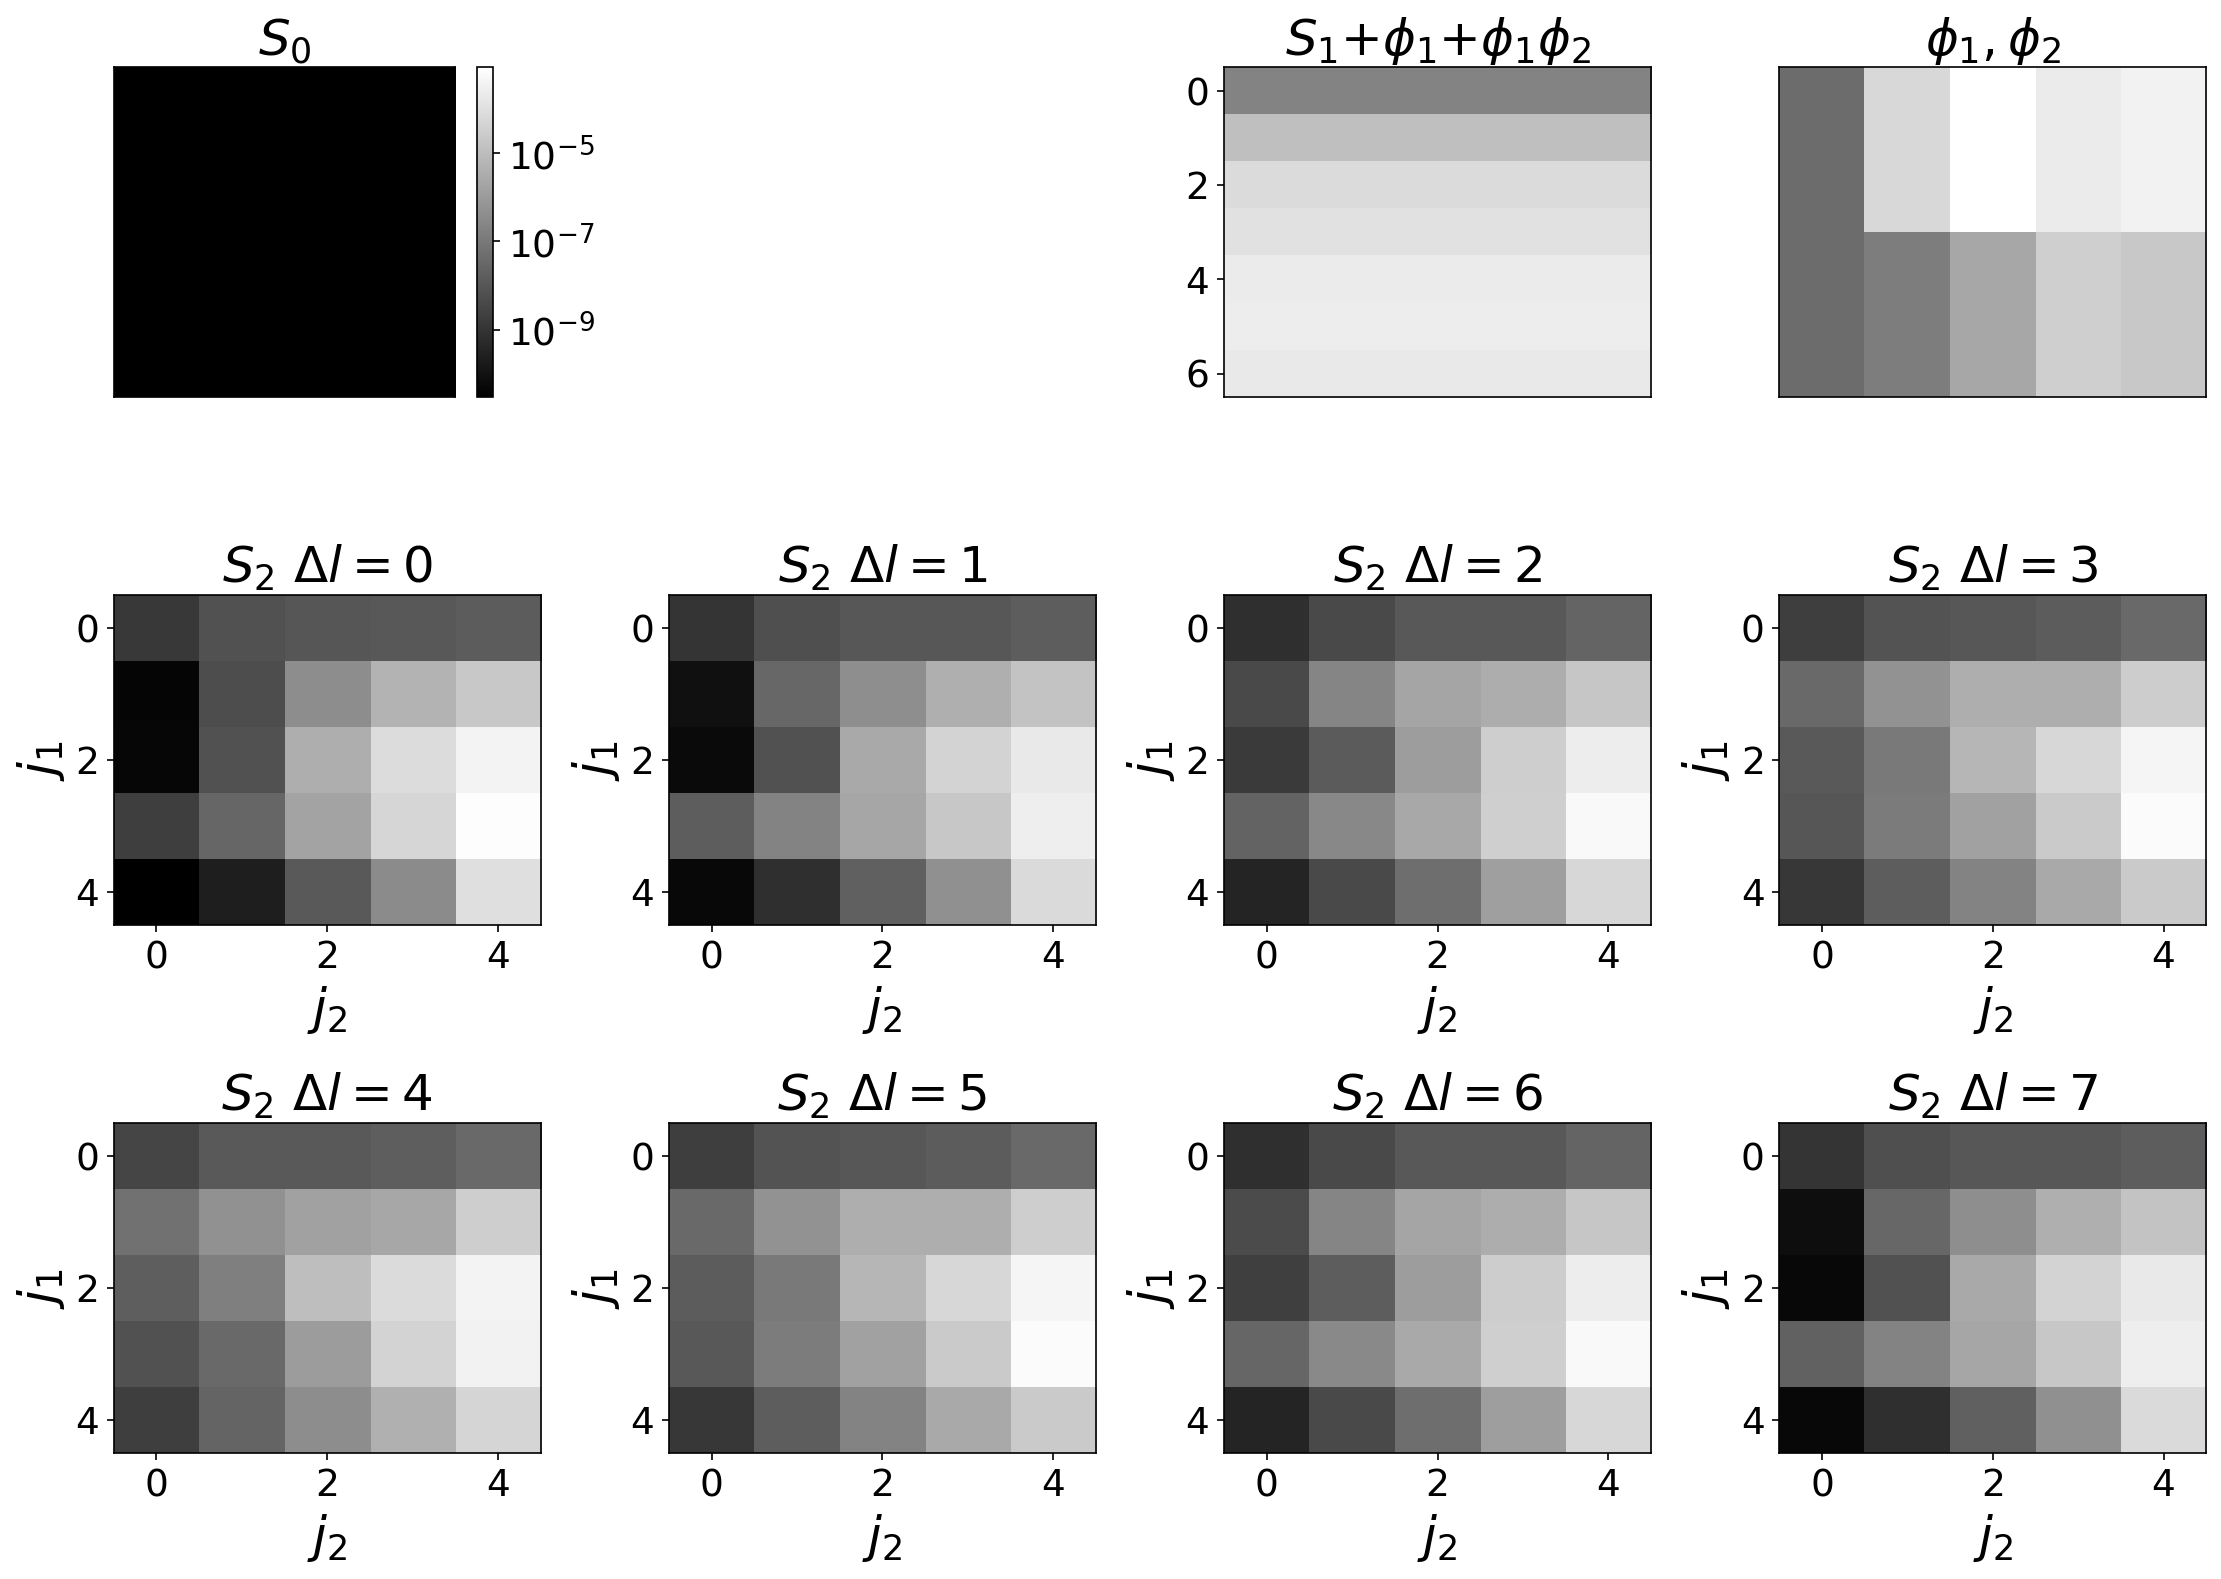

In [290]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 24
rcParams['font.family'] = 'sans-serif'

fig = plt.figure(figsize=(18,12),dpi=150)
ax = fig.add_subplot(3,4,1)    
im = ax.imshow(length_out[0:2].reshape(2,1),
         aspect='auto',
         cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$S_0$')
plt.colorbar(im)

J=5
ax = fig.add_subplot(3,4,3)    
im = ax.imshow(np.append(length_out[2:J+3],length_out[-1]).reshape(J+2,1),
         aspect='auto',
         cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

plt.title('$S_1$+$\phi_1$+$\phi_1 \phi_2$')
ax.axes.xaxis.set_ticks([])

J=5
L=8

for i in range(L):
    ax = fig.add_subplot(3,4,5+i)    
    im = ax.imshow(temp_out[:,:,i],
             aspect='auto',
             cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

    plt.xlabel('$j_2$')
    plt.ylabel('$j_1$')
    plt.title('$S_2$ $\Delta l = {}$'.format(i))

ax = fig.add_subplot(3,4,4)    
im = ax.imshow(length_out[J+3+J*J*L:J+3+J*J*L+2*J].reshape(2,J),
         aspect='auto',
         cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$\phi_1, \phi_2$')

fig.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

In [291]:
J = 5
L = 8
length_out = angles_mean_iso.reshape(219)
temp_out = length_out[J+3:J+3+J*J*L].reshape(J,J,L)

data_min = np.nanmin(length_out[2:])
data_max = np.nanmax(length_out[2:])

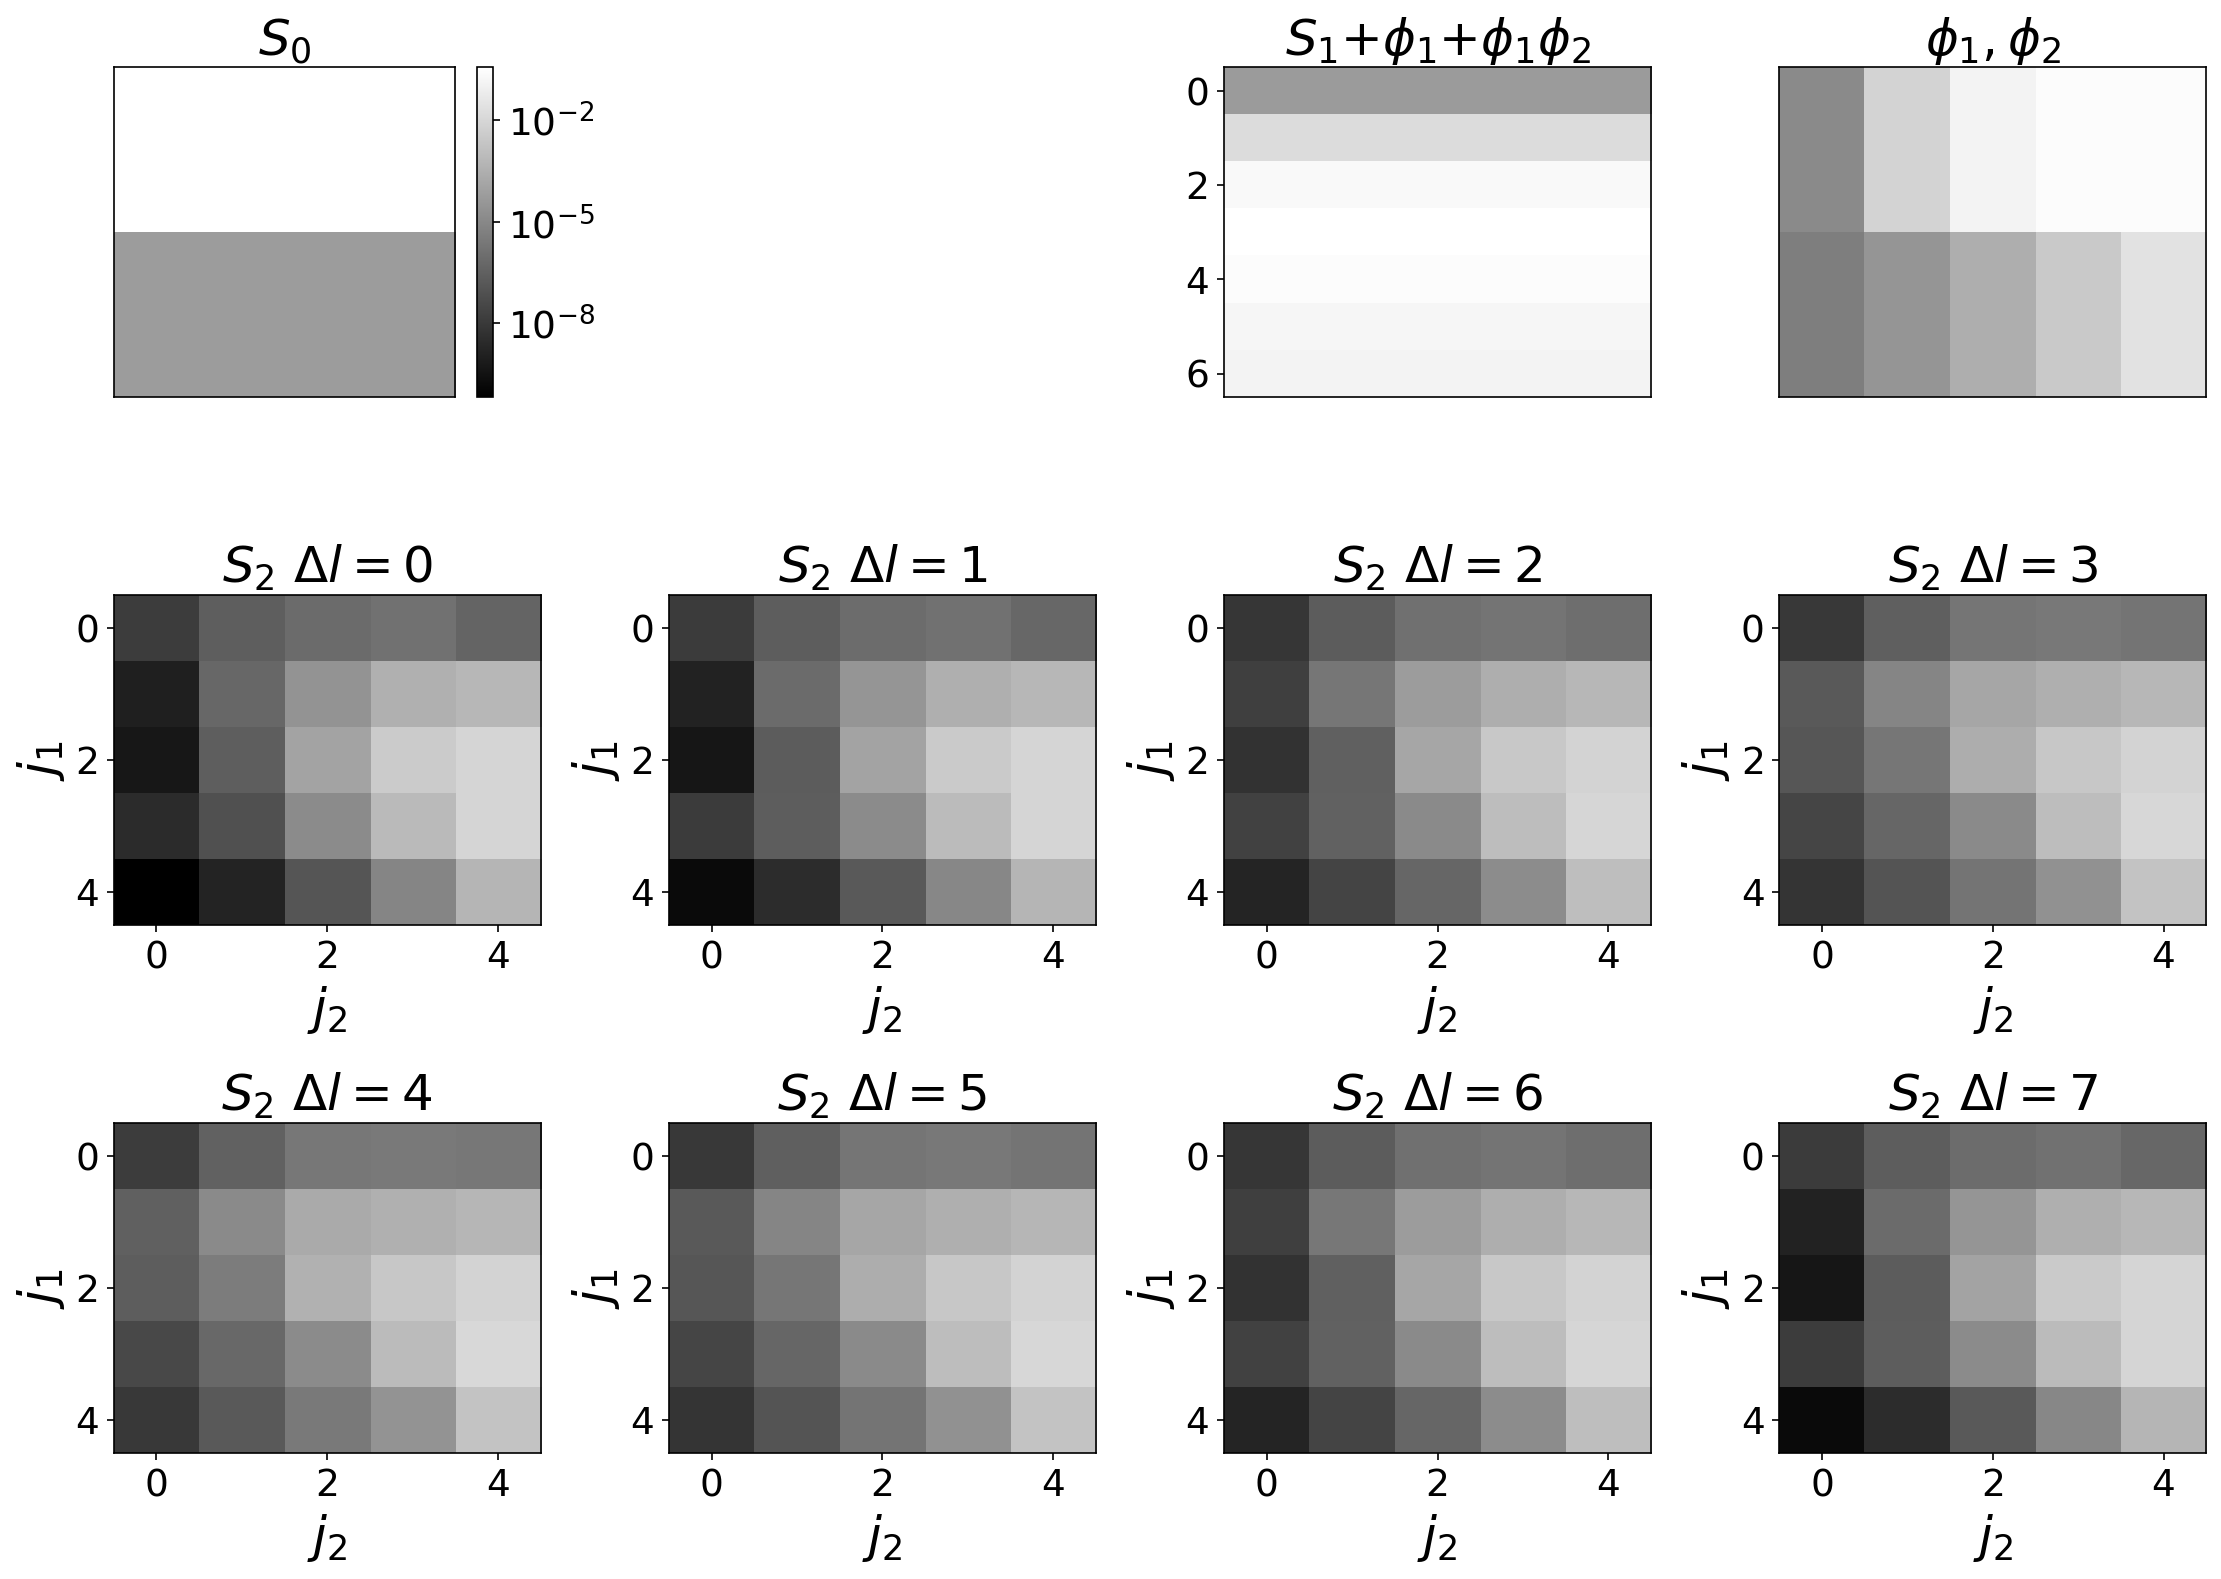

In [292]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 24
rcParams['font.family'] = 'sans-serif'

fig = plt.figure(figsize=(18,12),dpi=150)
ax = fig.add_subplot(3,4,1)    
im = ax.imshow(length_out[0:2].reshape(2,1),
         aspect='auto',
         cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$S_0$')
plt.colorbar(im)

J=5
ax = fig.add_subplot(3,4,3)    
im = ax.imshow(np.append(length_out[2:J+3],length_out[-1]).reshape(J+2,1),
         aspect='auto',
         cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

plt.title('$S_1$+$\phi_1$+$\phi_1 \phi_2$')
ax.axes.xaxis.set_ticks([])

J=5
L=8

for i in range(L):
    ax = fig.add_subplot(3,4,5+i)    
    im = ax.imshow(temp_out[:,:,i],
             aspect='auto',
             cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

    plt.xlabel('$j_2$')
    plt.ylabel('$j_1$')
    plt.title('$S_2$ $\Delta l = {}$'.format(i))

ax = fig.add_subplot(3,4,4)    
im = ax.imshow(length_out[J+3+J*J*L:J+3+J*J*L+2*J].reshape(2,J),
         aspect='auto',
         cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$\phi_1, \phi_2$')

fig.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

In [294]:
J = 5
L = 8
length_out = angles_std_iso.reshape(219)/angles_mean_iso.reshape(219)
temp_out = length_out[J+3:J+3+J*J*L].reshape(J,J,L)

data_min = np.nanmin(length_out[2:])
data_max = np.nanmax(length_out[2:])

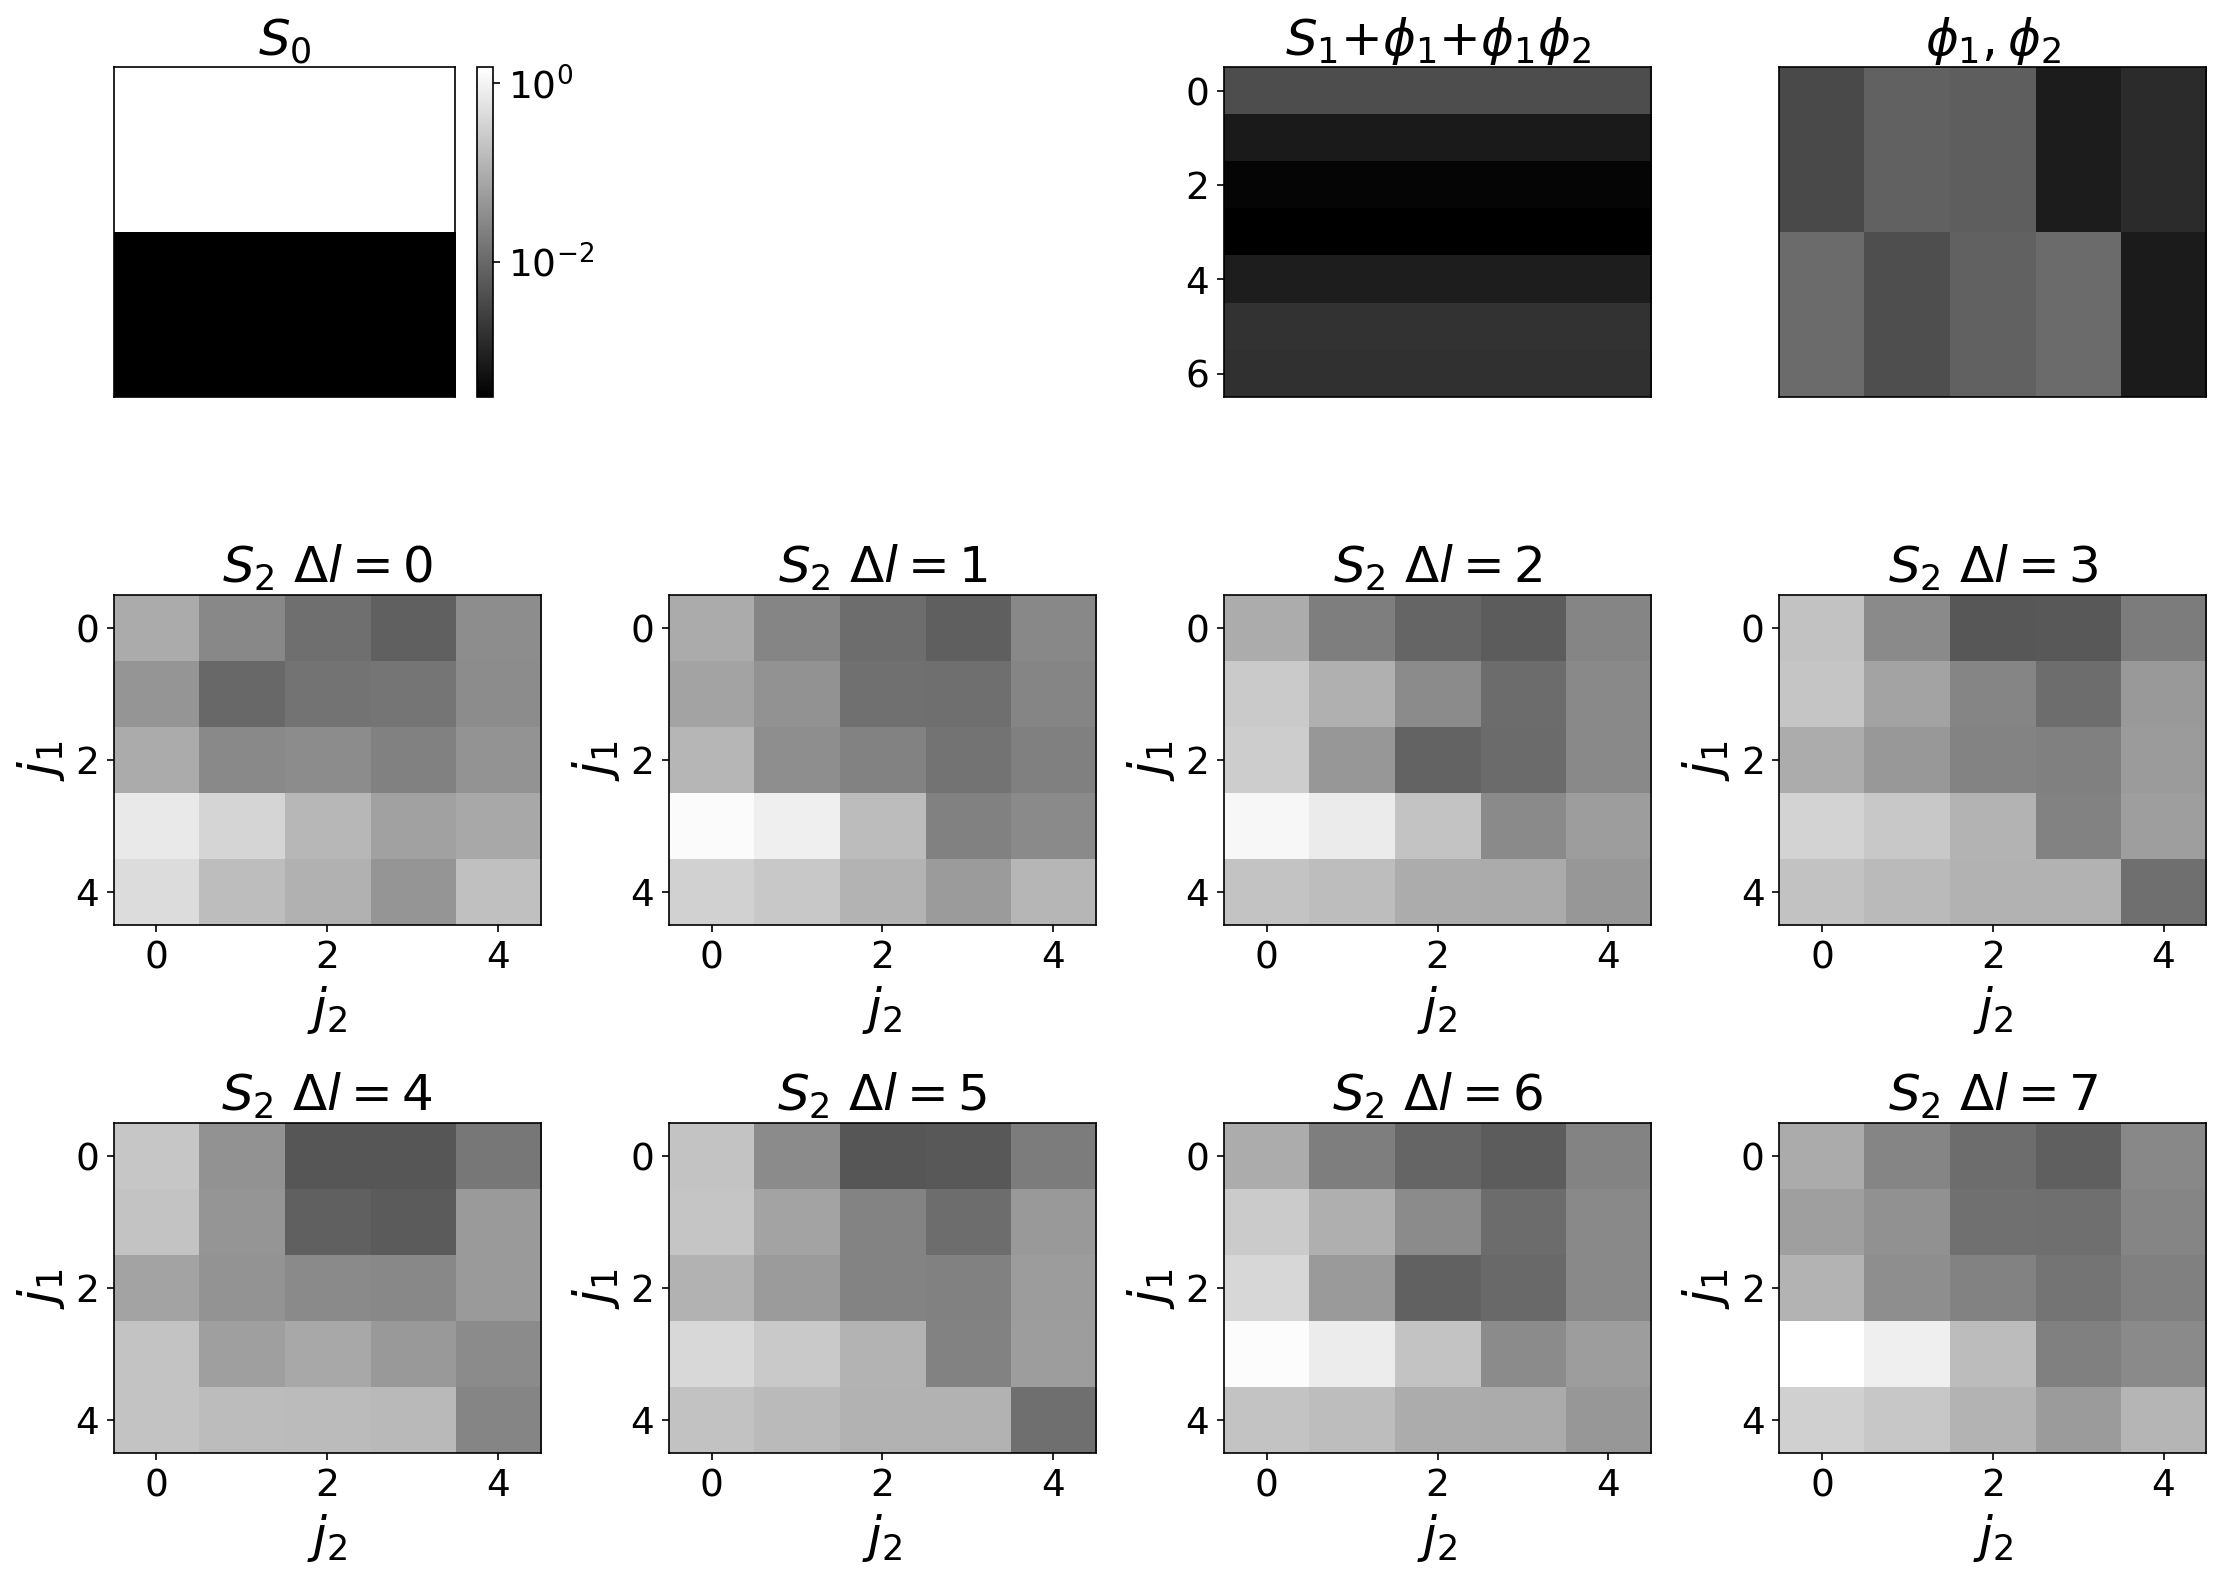

In [295]:
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 24
rcParams['font.family'] = 'sans-serif'

fig = plt.figure(figsize=(18,12),dpi=150)
ax = fig.add_subplot(3,4,1)    
im = ax.imshow(length_out[0:2].reshape(2,1),
         aspect='auto',
         cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$S_0$')
plt.colorbar(im)

J=5
ax = fig.add_subplot(3,4,3)    
im = ax.imshow(np.append(length_out[2:J+3],length_out[-1]).reshape(J+2,1),
         aspect='auto',
         cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

plt.title('$S_1$+$\phi_1$+$\phi_1 \phi_2$')
ax.axes.xaxis.set_ticks([])

J=5
L=8

for i in range(L):
    ax = fig.add_subplot(3,4,5+i)    
    im = ax.imshow(temp_out[:,:,i],
             aspect='auto',
             cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

    plt.xlabel('$j_2$')
    plt.ylabel('$j_1$')
    plt.title('$S_2$ $\Delta l = {}$'.format(i))

ax = fig.add_subplot(3,4,4)    
im = ax.imshow(length_out[J+3+J*J*L:J+3+J*J*L+2*J].reshape(2,J),
         aspect='auto',
         cmap='gray',
         norm = colors.LogNorm(vmin = data_min,vmax = data_max))

ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])

plt.title('$\phi_1, \phi_2$')

fig.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()